## Project Overview

In this project, I am answering the question whether music artists sing about the same things nowadays. I am exploring this question by utilising the lyrics of Taylor Swift, Ariana Grande, Olivia Rodrigo, and Burna Boy. Burna Boy was included in the mix of pop singers for a baseline comparison, since I believe it should be relatively easy for the models to pick up on the differnces between him and the rest of the presented artists. This project has the following structure:

1. Data discussion; <br>
2. Data cleaning + Explaratory Data Analysis;<br>
3. Mathematical and intuitive explanations of models used for the task; <br>
4. Model implementations; <br>
5. Performance metrics and visualisations for every model; <br>
6. Discussion + summary. <br><br>
The models I've discussed and implemented are Naive Bayes, Logistic Regression, LSTM, Transfer Learning (USE), and LDA topic modeling. All the predictive models perfgormed quite well with an accuracy score of > 60%. However, logistic regression achieved the highest accuracy: <br>

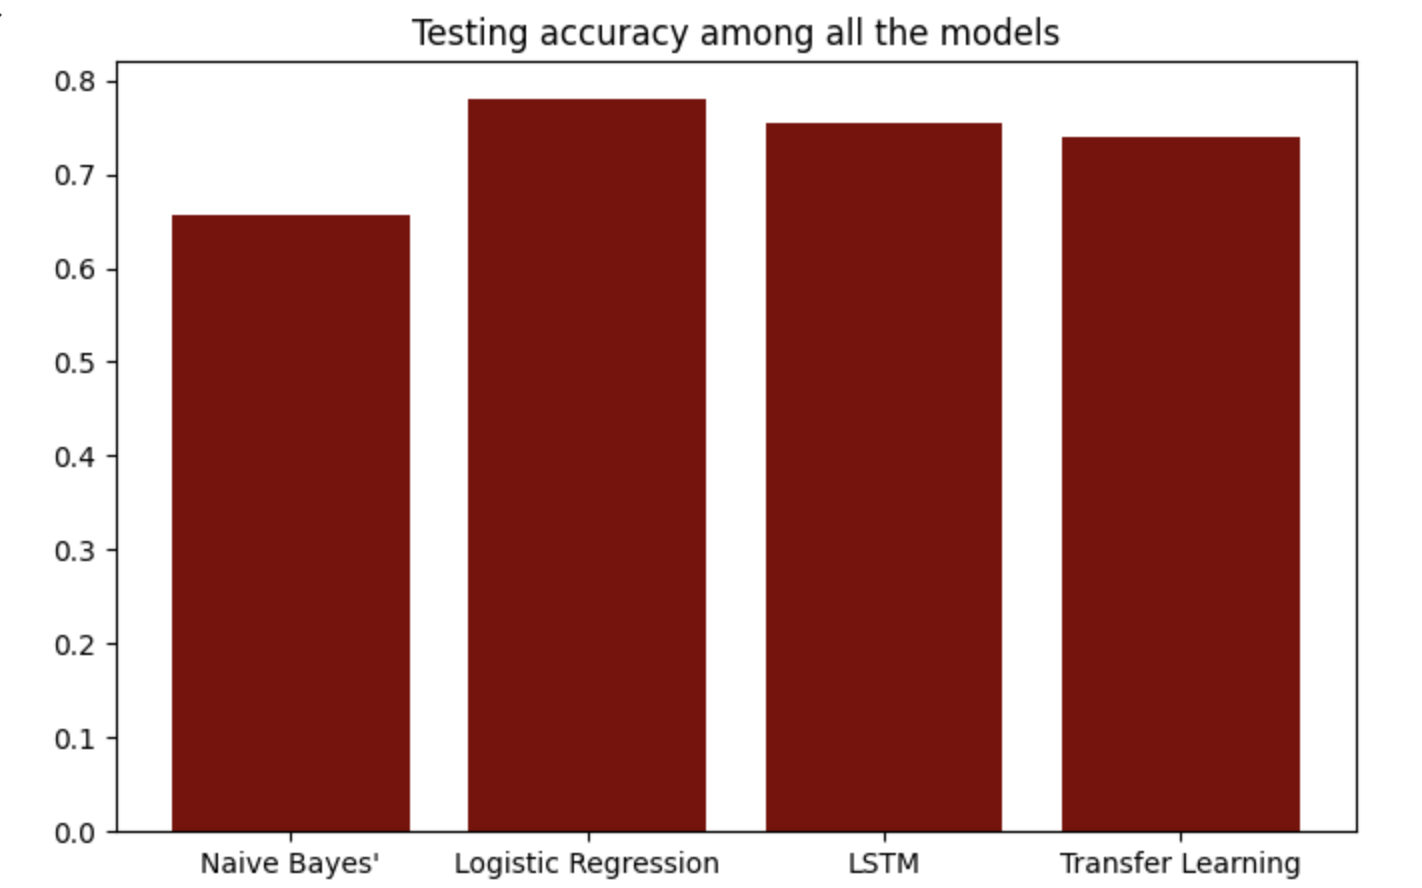

Specifically, logistic regression achieved the accuracy of 78%, sugesting that it is possible to differentiate between the artists lyrics. However, since machine learning can differentiate the artists based on some unseen features, to human beings, the songs might still appear to be about the same topics. That is why, I implemented a generative LDA model. LDA topic modeling showed that all of the artists sing about personal relationships, reminiscing and desires. While some have more of an emphasis on the desire an dothers on the memories, the topics appear to be quite similar. The only exception was Burna Boy due to the use of foreign language in his songs. Therefore, we could infer that all the studied artists (Taylor Swift, Olivia Rodrigo, Ariana Grande, Burna Boy) do sing about smilar topics with aylor Swift, Olivia Rodrigo, and Ariana Grande appearing to have most similarity as disclosed by LDA. However, machine learning is able to differentiate all the artists, suggesting that there are might be some underlying differences between the artists' lyrics.

## Data

**Question:** Is there an artist-specific difference in pop artists' lyrics? (Are the lyrics of pop artists the same?)
<br><br>
This question interests me because I've heard people say that the music today (especially pop music) is not like it used to be, and it is all the same. Specifically, multiple people mentioned that all pop music artists sing about the same things, which is why I decided to check that claim using machine and deep learning! In this project, I am focusing only on songs' lyrics. Using an artist's lyrics, I am going to predict whose lyrics they are.
<br><br>
**Data**
<br>
The data I am using have been gathered via web scraping using Genius API. With the API, I can access a link to a song of a specific artist. Using that link, I then scrape the lyrics of this song and put it in a .txt file.

### How the data was obtained: Web Scraping

First, I need to collect the data from the web. To do so, I am going to use Genius API which allows me to easily browse through Genius' songs, artists, and lyrics. I am collecting 100 songs from Taylor Swift, Ariana Grande, Olivia Rodrigo, and Burna Boy. I've chosen 3 pop artists (Taylor Swift, Ariana Grande, Olivia Rodrigo) because there is a common view that all pop music sounds the same and is about the same things. So, I am focusing on pop music for this assignment. However, I also included an afro beats artist, Burna Boy, for comparison. Comparing how well the network does differentiating the lyrics from the pop artists from one another to how well it does differentiating the pop lyrics from Afrobeats would provide useful information as to whether the lyrics are indeed similar in pop music or the model is simply bad at classification.

In [ ]:
GENIUS_API_TOKEN='6G9Ce-jNWDxuptmHVF3D-8e3rsYDe8HmWYzr9oQZO5QJ3DQ6KGJYRgcB179RLHXU'
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import os
import re

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def fetch_artist_info(artist, page_number):
    """
    Makes a request to the Genius API to fetch information about an artist.

    Args:
    artist (str): Name of the artist to search for.
    page_number (int): Page number for the API request (pagination).

    Returns:
    Response object from the requests library.
    """
    base_api_url = 'https://api.genius.com'
    auth_headers = {'Authorization': 'Bearer ' + GENIUS_API_TOKEN}
    search_endpoint = base_api_url + '/search?per_page=10&page=' + str(page_number)
    search_parameters = {'q': artist}
    api_response = requests.get(search_endpoint, data=search_parameters, headers=auth_headers)
    return api_response

def fetch_song_urls(artist, max_songs):
    """
    Fetches song URLs from Genius API for a given artist up to a specified limit.

    Args:
    artist (str): Name of the artist.
    max_songs (int): Maximum number of song URLs to fetch.

    Returns:
    List of song URLs.
    """
    current_page = 1
    fetched_songs = []

    while True:
        response = fetch_artist_info(artist, current_page)
        response_json = response.json()

        # Extracting song information
        artist_songs = []
        for hit in response_json['response']['hits']:
            if artist.lower() in hit['result']['primary_artist']['name'].lower():
                artist_songs.append(hit)

        # Extracting URLs from song information
        for song in artist_songs:
            if len(fetched_songs) < max_songs:
                song_url = song['result']['url']
                fetched_songs.append(song_url)

        # Check if the song capacity is reached
        if len(fetched_songs) == max_songs:
            break
        else:
            current_page += 1

    print('Found {} songs by {}'.format(len(fetched_songs), artist))
    return fetched_songs

In the code cell below I am applying the function to get the links of 130 Olivia Rodrigo songs. I used the function above to get 200 songs from Taylor Swift, Burna Boy and Ariana Grande as well. I am getting only 130 songs from Olivia Rodrigo because she does not yet have many songs.

In [ ]:
# Extracting 200 Taylor Swift song links
taylor_swift_songs = fetch_song_urls('Taylor Swift', 200)

Found 200 songs by Taylor Swift


The function below ensures that I can access the webpage and I am not block by providing me with a proxy link.

In [ ]:
from urllib.parse import urlencode
API_KEY = 'e0ed1d5c-7bec-4244-9e91-3d1f22bb755f'

def get_scrapeops_url(url):
  """
  Outputs a proxy ScareOps link given the original link

  Args:
  url (str): the original link for which the proxy link is needed;

  Returns:
  proxy_url (str): a proxy link
  """
  payload = {'api_key': API_KEY, 'url': url}
  proxy_url = 'https://proxy.scrapeops.io/v1/?' + urlencode(payload)
  return proxy_url

Having gotten a proxy link, I can start going through each one of the ~200 songs of a given artist without the fear of being blocked. In the code snippet below, I am going through every song's link and saving the lyrics into a JSON file. This means that after I've run the code below for each one of the artists, I will have 3 JSON files containing the lyrics to ~200 of their songs.

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import os
import json
from tqdm import tqdm

# Initialize a dictionary to hold song titles and lyrics
lyrics_dict = {}

for song in tqdm(taylor_swift_songs, desc="Processing Songs"):
    link = get_scrapeops_url(song)
    soup = BeautifulSoup(requests.get(link).content, 'lxml')
    lyrics = ''
    for tag in soup.select('div[class^="Lyrics__Container"], .song_body-lyrics p'):
        t = tag.get_text(strip=True, separator='\n')
        if t:
            # Remove identifiers like chorus, verse, etc
            t = re.sub(r'[\(\[].*?[\)\]]', '', t)
            lyrics += os.linesep.join([s for s in t.splitlines() if s]) + os.linesep

    # Add the song and its lyrics to the dictionary
    lyrics_dict[song] = lyrics.strip()

# Save the dictionary to a JSON file
with open('taylor_swift.json', 'w', encoding='utf-8') as file:
    json.dump(lyrics_dict, file, ensure_ascii=False, indent=4)


Processing Songs: 100%|██████████| 200/200 [17:49<00:00,  5.35s/it]


## Data Conversion

In this section, I am converting the obtained .json files into individual pandas data frames. So, each artist will have an individual data frame with the links and lyrics to their 200 songs (130 songs in Olivia Rodrigo's case). Having the data in the padas data frame allows me to work with the data more easily and provides an easy way for me to get to know it better.

In [ ]:
import pandas as pd
import json

def read_lyrics_to_dataframe(file_path):
    """
    Reads a JSON file where keys are song titles and values are lyrics.
    Transforms this data into a Pandas DataFrame.

    Args:
    file_path (str): The file path of the JSON file to be read.

    Returns:
    DataFrame: A Pandas DataFrame with columns 'Song Title' and 'Lyrics'.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        lyrics_data = json.load(file)

    # Convert the dictionary to a list of dictionaries for easy DataFrame conversion
    formatted_data = [{'Link': title, 'Lyrics': lyrics} for title, lyrics in lyrics_data.items()]
    dataframe = pd.DataFrame(formatted_data)

    return dataframe

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
ariana_grande_df = read_lyrics_to_dataframe("/content/ariana_grande.json")
burna_boy_df = read_lyrics_to_dataframe("/content/burna_boy.json")
olivia_rodrigo_df = read_lyrics_to_dataframe("/content/olivia_rodrigo.json")
taylor_swift_df = read_lyrics_to_dataframe("/content/taylor_swift.json")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Checking how the dataframe looks like
olivia_rodrigo_df.head()

Link  \
0  https://genius.com/Olivia-rodrigo-drivers-lice...   
1   https://genius.com/Olivia-rodrigo-deja-vu-lyrics   
2  https://genius.com/Olivia-rodrigo-good-4-u-lyrics   
3   https://genius.com/Olivia-rodrigo-vampire-lyrics   
4   https://genius.com/Olivia-rodrigo-happier-lyrics   

                                              Lyrics  
0  I got my driver's license last week\nJust like...  
1  Car rides to Malibu\nStrawberry ice cream, one...  
2  Well, good for you, I guess you moved on reall...  
3  Hate to give the satisfaction asking how you'r...  
4  We broke up a month ago\nYour friends are mine...

## Data Cleaning & Pre-Processing

I am not going to use the "links" column, so I will not do much cleaning on it. However, I will have to get rid of all the punctuation, capital letters, "\n" signs, and stop words from the lyrics column before performing exploratory data analysis on it and converting it to numerical representations.

In [ ]:
import string
import re

def clean_lyrics(dataframe):
    """
    Cleans the 'Lyrics' column in the provided DataFrame. The cleaning
    includes converting text to lower case, removing punctuation, and
    removing newline characters and text within brackets.

    Args:
    dataframe (DataFrame): A Pandas DataFrame with a 'Lyrics' column to be cleaned.

    Returns:
    DataFrame: The DataFrame with the 'Lyrics' column cleaned.
    """
    # Cleaning a single song lyrics
    def clean_lyric(lyric):
        # Converting the string to lower case
        lyric = lyric.lower()
        # Removing punctuation
        lyric = lyric.translate(str.maketrans('', '', string.punctuation))
        # Removing the brackets
        lyric = re.sub(r'\[.*?\]', '', lyric)
        # Removing newline characters (\n)
        lyric = lyric.replace('\n', ' ')
        # Removing numbers
        lyric = re.sub(r'\d+', '', lyric)
        return lyric

    # Applying the cleaning function to each row in the 'Lyrics' column
    dataframe['Lyrics'] = dataframe['Lyrics'].apply(clean_lyric)

    return dataframe


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Cleaning all the dataframes
ariana_grande_cleaned = clean_lyrics(ariana_grande_df)
burna_boy_cleaned = clean_lyrics(burna_boy_df)
taylor_swift_cleaned = clean_lyrics(taylor_swift_df)
olivia_rodrigo_cleaned = clean_lyrics(olivia_rodrigo_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
olivia_rodrigo_cleaned.head()

Link  \
0  https://genius.com/Olivia-rodrigo-drivers-lice...   
1   https://genius.com/Olivia-rodrigo-deja-vu-lyrics   
2  https://genius.com/Olivia-rodrigo-good-4-u-lyrics   
3   https://genius.com/Olivia-rodrigo-vampire-lyrics   
4   https://genius.com/Olivia-rodrigo-happier-lyrics   

                                              Lyrics  
0  i got my drivers license last week just like w...  
1  car rides to malibu strawberry ice cream one s...  
2  well good for you i guess you moved on really ...  
3  hate to give the satisfaction asking how youre...  
4  we broke up a month ago your friends are mine ...

Now that the data frames are cleaned and do not have punctuation, brackets, and new line characters, we can get rid of stop words so that the model does not try to remember words like "the", and "a" and assign them to a specific artist (Taylor Swift, Burna Boy, etc). This will help ensure the model is not learning useless features and that the text is normalized.

In [ ]:
# Using wordcloud "stopwords" set
stopwords = set(STOPWORDS)
# Updating the set with custom stopwords such as the names of the artists
# that perform the song
stopwords.update(["will", "need", "s", "intro", "outro", "chorus", "verse",
                  "nicki", "minaj", "ariana", "grande", "taylor", "swift",
                  "olivia", "rodrigo", "burna", "boy", "ill", "im", "dont",
                  "aint", "ye", "yeah", "cause", "youre"])
# Keeping "with" and "up"
stopwords.discard("with")
stopwords.discard("up")

def remove_stopwords(text):
    """
    Removes custom stop words from a text.

    Args:
    text (str): The text from which to remove the stop words.

    Returns:
    str: The text with stop words removed.
    """
    return ' '.join([word for word in text.split() if word not in stopwords])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
ariana_grande_cleaned['Lyrics'] = ariana_grande_cleaned['Lyrics'].apply(remove_stopwords)
burna_boy_cleaned['Lyrics'] = burna_boy_cleaned['Lyrics'].apply(remove_stopwords)
taylor_swift_cleaned['Lyrics'] = taylor_swift_cleaned['Lyrics'].apply(remove_stopwords)
olivia_rodrigo_cleaned['Lyrics'] = olivia_rodrigo_cleaned['Lyrics'].apply(remove_stopwords)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's see how the lyrics look after we've got rid of the stop words!

In [ ]:
olivia_rodrigo_cleaned.head()

Link  \
0  https://genius.com/Olivia-rodrigo-drivers-lice...   
1   https://genius.com/Olivia-rodrigo-deja-vu-lyrics   
2  https://genius.com/Olivia-rodrigo-good-4-u-lyrics   
3   https://genius.com/Olivia-rodrigo-vampire-lyrics   
4   https://genius.com/Olivia-rodrigo-happier-lyrics   

                                              Lyrics  
0  got drivers license last week always talked ex...  
1  car rides malibu strawberry ice cream one spoo...  
2  well good guess moved really easily found new ...  
3  hate give satisfaction asking now hows castle ...  
4  broke up month ago friends mine know know youv...

### Exploratory Data Analysis

Now that we've cleaned the data, we can visualise it and get to know it better! One way to do so is via word clouds.

In [ ]:
ariana_lyrics = ' '.join(ariana_grande_cleaned["Lyrics"].astype(str))
burnaboy_lyrics = ' '.join(burna_boy_cleaned["Lyrics"].astype(str))
taylor_lyrics = ' '.join(taylor_swift_cleaned["Lyrics"].astype(str))
olivia_lyrics = ' '.join(olivia_rodrigo_cleaned["Lyrics"].astype(str))
all_artists_lyrics = [ariana_lyrics, burnaboy_lyrics, taylor_lyrics, olivia_lyrics]
artist_names = ["Ariana Grande", "Burna Boy", "Taylor Swift", "Olivia Rodrigo"]

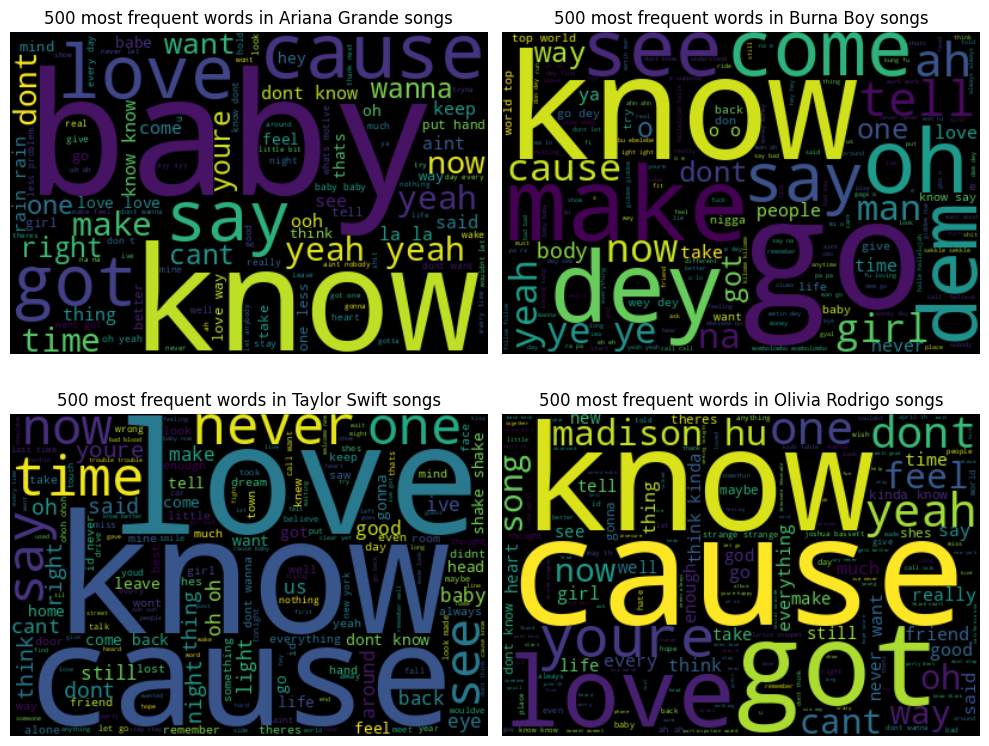

In [ ]:
plt.figure(figsize=(10, 8), dpi=100)
for i, artist_lyrics in enumerate(all_artists_lyrics):
  wordcloud = WordCloud(background_color="black",
                        width=400,
                        height=270,
                        max_words=500,
                        repeat=False).generate(artist_lyrics)

  plt.subplot(2, 2, i + 1)
  plt.imshow(wordcloud, interpolation='bilinear')
  artist_name = artist_names[i]
  plt.title(f'500 most frequent words in {artist_name} songs')
  plt.axis('off')

plt.tight_layout()
plt.show()

The word clouds generated above contain the 500 most frequent words used in Ariana Grande's, Burna Boy's, Taylor Swift's, and Olivia Rodrigo's songs. We can see significant overlap between the most common words in the pop singers' word clouds (Ariana Grande, Taylor Swift, Olivia Rodrigo). Some of the most common words in their repertoire include love, know, and cause. While "know" is also commonly used in Burna Boy's songs, other commonly used words are different from those observed in the wordclouds of the pop singers. This means that his songs are a good choice for a "control" group because they provide a great comparison opportunity. This is because it is much easier to differentiate between Burna Boy's lyrics and any of the other pop artists than to differentiate the pop artists' lyrics from one another. Hence, if the model is classifying the lyrics poorly, we can look at how it is classifying Burna Boy's lyrics since they are much different from the rest and should be easy to distinguish for a model that learns something. Therefore, if the model cannot differentiate between say Olivia Rodrigo and Burna Boy, then the model is likely not learning a lot and needs revision. However, if the model is having trouble classifying the pop lyrics but distinuishes afro beats lyrics easily, then the model is good and the given pop artists do indeed have similar lyrics.

It also should be noted that we have some words like "dem" or "dey" in Burna Boy's word cloud. This is not due to the poor cleaning process. I chose not to get rid of these words because they are a key characteristic of the artist's lyrics that he sings in multiple languages. Moreover, this allows for easier comparison between the artist and the pop artists, which will be helpful in understanding how well the model is doing.

## Task Discussion

The problem I am working on is classifying song lyrics as belonging to Taylor Swift, Olivia Rodrigo, Ariana Grande, or Burna Boy. As mentioned above, the primary task is to understand whether pop artists' lyrics are the same or not. I've included Burna Boy, an afro beats artist, for baseline comparison.

Firstly, we need to combine all 4 pandas dataframes into one with artist labels next to the lyrics column.

In [ ]:
ariana_grande_cleaned['Artist'] = 'Ariana Grande'
taylor_swift_cleaned['Artist'] = 'Taylor Swift'
olivia_rodrigo_cleaned['Artist'] = 'Olivia Rodrigo'
burna_boy_cleaned['Artist'] = 'Burna Boy'

# Combining the dataframes
combined_df = pd.concat([ariana_grande_cleaned, olivia_rodrigo_cleaned,
                         taylor_swift_cleaned, burna_boy_cleaned], ignore_index=True)

# Removing the 'Link' column
combined_df.drop('Link', axis=1, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
combined_df.head()

Lyrics         Artist
0  thought id end up with sean wasnt match wrote ...  Ariana Grande
1  yeah breakfast tiffanys bottles bubbles girls ...  Ariana Grande
2  love move love touch one said done youll belie...  Ariana Grande
3  ive night ive day got walkin side side talkin ...  Ariana Grande
4  right now state mind wanna time aint got tears...  Ariana Grande

Now that we've combined the data frames into one, we can shuffle it so that the model does not simply learn to identify one class. The shuffling will allow the model not to "get used" to a certain data pattern. It will allow it to learn from multiple patterns, making its learning more meaningful and generalizable. After shuffling the data we will also divide the data into training, validation, and test sets.

We will be using the training set, 80% of the data, to train the model so that it learns the hidden patterns of the data. The validation set, 10% of the data, will be used to assess whether the model is improving or not. Having a validation set allows us to see how well the model is performing on unseen data and whether some parameters should be changed. The test set is going to be used to evaluate the model's performance. After the final performance metric is calculated, we are not going to make any changes to the model at hand.

I am using the 80-10-10 split for the data because I do not have a lot of data and I want to maximise the model's learning.

In [ ]:
# Shuffling the songs order
shuffled_df = combined_df.sample(frac = 1, random_state = 42)
shuffled_df.head()

Lyrics          Artist
468  oh carolina creeks running veins lost born lon...    Taylor Swift
148  hmm might think crazy way ive cravin put quite...   Ariana Grande
302  brutal jealousy jealousy drivers license compl...  Olivia Rodrigo
355  green color grass used read centennial park us...    Taylor Swift
515  said oh marvelous tune best night never forget...    Taylor Swift

In [ ]:
# Encoding the artists numerically
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(shuffled_df['Artist'])
# Creating a mapping to use later
artist_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
labels_df = pd.DataFrame(labels, columns=['Artist Encoded'])

In [ ]:
# Checking the mapping for artists
artist_mapping.keys()

dict_keys(['Ariana Grande', 'Burna Boy', 'Olivia Rodrigo', 'Taylor Swift'])

In [ ]:
labels_df.head() # Checking how the numerically encoded artists look

Artist Encoded
0               3
1               0
2               2
3               3
4               3

Comparing to the first 5 rows of the dataframe above, we see that we've encoded the artists correctly.

In [ ]:
# training, validation, test set division
from sklearn.model_selection import train_test_split
# test split
data, test_data, labels, test_labels = train_test_split(shuffled_df.Lyrics.to_numpy(),
                                                        labels_df['Artist Encoded'].to_numpy(),
                                                        test_size = 0.1,
                                                        random_state = 42)
# train & validation split
train_data, val_data, train_labels, val_labels = train_test_split(data,
                                                                  labels,
                                                                  test_size = (0.1/0.9),
                                                                  random_state = 42)

In [ ]:
# checking the shapes of the training, validation and test sets
train_data.shape, train_labels.shape, val_data.shape, val_labels.shape, test_data.shape, test_labels.shape

((584,), (584,), (73,), (73,), (73,), (73,))

## Model Selection

I am going to use Naive Bayes' and Logistic Regression models to establish a baseline. My previous assignment (Assignment 1) contains the math behind these models as well as how exactly they are learning (loss functions, gradient descent, etc). Therefore, I will spend more time explaining the logic behind feedforward neural networks, backpropagation, RNNs, LSTM, and transfer learning in this section. All the models (including Naive Bayes' and Logistic Regression) will be implemented in the next section.

The main model I am working with is RNN, namely LSTM. However, to understand the logic behind these more complex models, I believe it is necessary to discuss a simple feedforward neural network, backpropagation and gradient descent first. This will allow us to understand how RNNs and LSTMs work more easily since these models use the same logic as in feedforward neural networks.

### Feedforward Neural Network

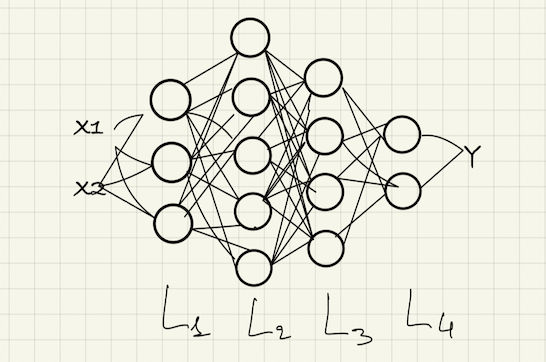

*Figure 1. Simple fully connected feed forward neural network with 4 hidden layers ($L_1$ - $L_4$).*

The figure above demonstrates a simple feedforward neural network, where $X_1$ and $X_2$ are the inputs, $Y$ is the output, the edges (connections) represent weights, and the circles represent neurons that also carry biases. The presented neural network is fully connected, meaning that each neuron is connected to each of the neurons in the next layer. Layers L1-L4 are hidden layers, and the output of each of the hidden layers is the input of the next one.

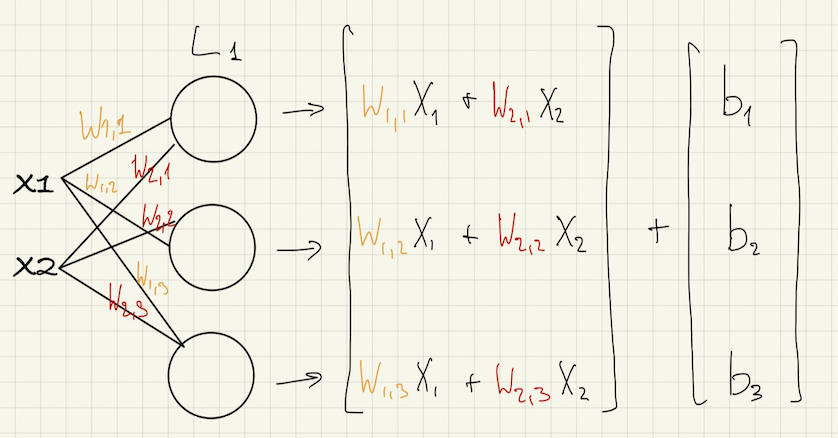

*Figure 2. The first hidden layer, $L_1$, of the feedforward network shown on figure 1. The graph shows the weights ($w_{1,1}, w_{1,2}, w_{1,3}, w_{2,1}, w_{2,2}, w_{2,3}$) between the inputs, $X_1$ and $X_2$, and the three neurons that carry biases. The matrices show the affine transformations the inputs go through in $L_1$.*

The first layer takes in two inputs: $X_1$ and $X_2$. Both inputs are connected to every neuron in the first hidden layer,$L_1$. For instance, $X_1$ is connected to the first neuron via $w_{1, 1}$, to the second one via $w_{1, 2}$, and to the third one via $w_{1, 3}$. These connections represent weights each neuron assigns to each input. So, first each input is transformed by the weight assigned to it by each neuron. Then, these weighted inputs are summed up together and a bias term ($b_1, b_2, b_3$) is added. After the input undergoes the affine transformations, it is passed through an activation function. The sigmoid activation function is commonly used and has the following form:

$\sigma(x) = \frac{1}{1+e^{-x}}$

This function pushes the output to be in between 0 and 1, which is especially useful for models predicting the probability of a certain outcome. The bias terms mentioned earlier are used to essentially "push" the activation function to left or right, which helps the model better fit the data and, thus, make better predictions. Both weights and biases are learnt through the training process to fit the data at hand.

Considering the activation function, the output of $L_1$ can be written as follows:

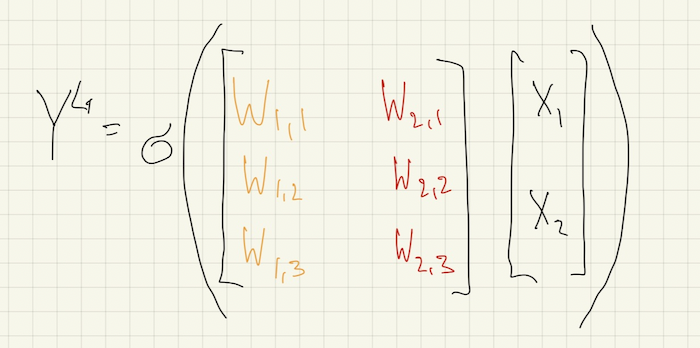

*Figure 3. The output of the first hidden layer of the neural network shown in figure 1. $Y^{L_1}$ denotes the output of $L_1$. The output is written as a matrix multiplication of the inputs and the weights matrix ($w_{1,1}, w_{1,2}, w_{1,3}, w_{2,1}, w_{2,2}, w_{2,3}$). The output also contains an activation function $\sigma$.*

The expression above incorporates the weight and bias transformations as well as the activation function. The shape of the output of the first hidden layer after the weight, bias transformation and activation function, is (3,1). This means that the input to the next hidden layer, $L_2$, is also of shape (3, 1). <br> <br> The second hidden layer, $L_2$, receives the $L_1$ output, $Y^{L_1}$ as its input. Then, every input to $L_2$ will undergo the same transformations (weights, bias, activation) as the inputs, $X_1, X_2$, underwent in hidden layer 1. Since there are 3 inputs and 5 neurons in the second hidden layer, $L_2$'s output will be of shape (5, 1). This output will then become the input of $L_3$. This forward propagation of the inputs through the network then leads to the final output, $Y$, which can be a probability that the input belongs to a certain class.

But what if the prediction is very wrong? How will the network improve?

### Backpropagation & Gradient Descent

Neural networks get better via the process called backpropagation. First, we need to assess how well the model is doing. This can be done via a cost ("loss") function:

$C(x) = (y_o - y_d)^2$

In the function above, $y_d$ is the desired outcome. For example, in a binary classification model, the desired outcome can be 1 but the model output, $y_o$, can be 0.65. This means that the model would assign "1" to the given inputs, however, it is only 65% confident and, hence, quite likely to make a mistake. This is why we would want to improve its accuracy.

A way to improve the accuracy is to adjust the weights the layers assign to its inputs. However, how do we know which weights contribute the most to the error?

We can assess the sensitivity of the error to perturbation in each weight by taking a partial derivative of the cost function (error) with respect to the weight: $\frac{\partial error}{\partial w_i}$

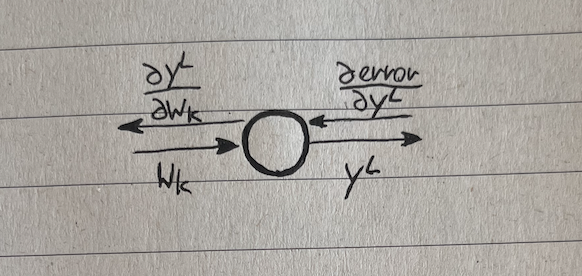

*Figure 4. Backpropagation in a single neuron. $Y^{L}$ represents the output of this neuron (layer consisting of one neuron), $W_k$ represents the $k$th weight input to the neuron. $\frac{\partial error}{\partial Y^{L}}$ is a partial derivative of the error with respect to the output ($Y^L$) of layer $L$. $\frac{\partial Y^{L}}{\partial W_k}$ is the partial derivative of the output of the given layer with respect to the $k$th weight $w_k$.*

Given a single neuron with a single input and output like on the image above, we would have to use a chain rule to compute the partial derivative of the error with respect to the weight. This is because the weights are not connected directly to the error. Rather, they undergo an affine transformation with weights and biases and then are passed through an activation function. After these transformations they become the input of another layer of neurons or lead to the final error. Thus, to calculate the error with respect to an $i$th weight $\frac{\partial error}{\partial w_i}$, we need to use the chain rule multiple times through all the neurons connecting $w_i$ to the error:

$\frac{\partial error}{\partial w_i} =$ $\frac{\partial error}{\partial Y^L}$$\frac{\partial Y^L}{\partial w_i}$

However, this calculation is only for a single neuron but we have a multitude of neurons in neural networks. In a case with a denser neural network, we would need to apply the chain rule at every layer for each neuron. However, our goal remains unchanged. That is, we still want to calculate the partial derivative of error of the network with respect to the change in weights. Since the error is the result of the inputs being passed through multiple hidden layers in the network, we need to calculate how much the change in the inputs of every layer (inputs of every layer are the outputs of the previous layer) affect its output.

This can be done using the Jacobian matrix. Specifically, we need to use the Jacobian matrices for every layer to propagate the gradient of the loss function back to the inputs. So, if there are $m$ neurons in a given hidden layer, then we have $m$ transformation functions $f_m$, and if there are $n$ inputs, we would have $x_n$ inputs. Then, the jacobian for a layer $L^k$, $k$th layer of the network, would be the following:

J = \begin{bmatrix}
\frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} & \cdots & \frac{\partial f_1}{\partial x_n} \\
\frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} & \cdots & \frac{\partial f_2}{\partial x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial f_m}{\partial x_1} & \frac{\partial f_m}{\partial x_2} & \cdots & \frac{\partial f_m}{\partial x_n}
\end{bmatrix}

Here, each term in the matrix is a partial derivative of the output of the neuron function with respect to the each of the inputs.

Tying this all together, we can come up with the following algorithm that uses Jacobian matrices to propagate the error through the network and adjust the weights:

*Step 1:* <br>
Calculate $\frac{\partial error}{\partial Y^L}$, which is the first term in the expression for $\frac{\partial error}{\partial w_i}$ above.

*Step 2:*<br>
For each layer, $L$, compute the Jacobian, $J^L$, of $f^L$ (the weighting + bias + activation function transformation) with respect to $x^L$ (inputs to the given layer $L$). As mentioned above, every element in this Jacobian is the partial derivative of the output with respect to the input: $\frac{\partial y^L_i}{\partial x^L_j}$, where $y^L_i$ is the output of $i$th neuron in layer $L$, and $x^L_j$ is the $j$th input to the layer $L$.

*Step 3:*<br>
For each layer, $L$, propage the error gradient to the inputs of each layer using the Jacobian matrix for the given layer: <br><br>
$\frac{\partial error}{\partial x^L} =$ $J^L$$\frac{\partial error}{\partial y^L}$

$\frac{\partial error}{\partial x^L}$ computed in this step is essentially $\frac{\partial error}{\partial y^{L-1}}$, which is then used to compute the eror gradient with respect to the weights of the given layer in the next step.

*Step 4:* <br>
Compute the error gradient with respect to the weights of the given layer, $L$: <br><br>
$\frac{\partial error}{\partial w^L_{m, n}}$ $= \sum_{k}$$\frac{\partial error}{\partial y^L_i}$$\frac{\partial y^L_i}{\partial w^L_{m, n}}$ <br><br>
The calculated expression can be rewritten in the following way: <br>
$\frac{\partial error}{\partial w^L_{m, n}}$ = $\nabla W^L*error$

*Step 5*<br>
Once we have calculated the gradient with respect to the weights, we can update the weights using the gradient descent rule:

$W_{new} = W_{old} - a \nabla W^Lerror$

In the gradient descent expression above, $W_{new}$ are the updated weights, $W_{old}$ are the old weights, $a$ is the learning rate (between 0 and 1), and $\nabla W^Lerror$ denotes the error gradient with respect to the weights. $\nabla W^Lerror$ points at the direction of the steepest increase of the cost function, which is why we change the weight in the opposite direction, thus, reducing the loss.

We are applying this backpropagation algorithm after every forward pass until convergence. With each cycle, the network should learn more about the data and adjust the weights accordingly, thereby reducing the error.

### RNNs: Recurrent Neural Networks

Now that we have established what feedforward neural network, backpropagation, the Jacobian and gradient descent are, we can move on to RNNs. I am using RNN in this task because I am analysing and classifying text data. In order to do so effectively, the model should consider/remember all the words in the sentence to fully understand it. RNNs perform the same operation on every element of the sequence (text in my case), with the output depending on the previous computations. This allows them to maintain the information carried by the previous sequences.

RNNs have the following structure:

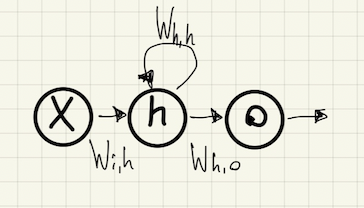

*Figure 5. RNN network structure where $x$ is the input, $h$ is the hidden state, $o$ is the output, $W_{i, h}$ is the weight matrix for input-to-hidden connections, $W_{h, h}$ is the weight matrix for hidden-to-hidden connections, and $W_{h,o}$ is the weight matrix for hidden-to-output connections.*

To better understand the RNN algorithm discussed later, it might be useful to refer to the "unrolled" loop structure while reading the algorithm:

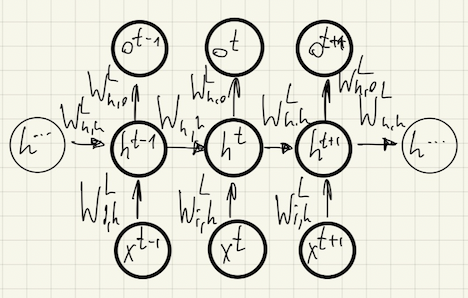

*Figure 6. Unrolled structure (3 layers are unrolled) of RNN model.*

The algorithm of RNN implementation is the following: <br><br>
*Step 1: Initialisation*<br>
Initialise weight matrices ($W_{h,h}, W_{i, h}, W_{h, o}$) using a random distribution, and setting biases, $b$, to zeros.

*Step 2: Forward pass* <br>
For each time step, $t$, we need to update the hidden state, $h_t$. The model uses the input $x_t$ and the previous hidden state ($h_{t-1}$) to calculate the hidden state for every time step. It then multiplies them by their respective weight matrices and adds the hidden state bias, $b_h$:

$h_t = f(W_{h, h}h_{t-1}+W_{i,h}x_t+b_h)$

Depending on the task at hand, the model might also need to calculate the output state. For example, we would calculate the output for every time step if had a many-to-many sequence task such as translating a sentence from one language to another. If the output calculation is needed, we would use the following expression:

$o_t = g(W_{h,0}h_t+b_o)$

Where $o_t$ is the output for time step $t$, and $b_o$ is the bias term for the output, and $g()$ is an activation function. However, I am working on a classification model, hence, an output calculation is not needed at every step.

*Step 3: Computing the loss* <br>
For a classification task, we calculate the loss/error at the final time step using cross-entropy. If the model outputs a vector of probabilities $p$ representing the predicted probability distribution over $C$ classes, then the cross-entropy formula would be:

$L = -\sum_{C=1}^Cy_Clog(p_C)$

Where $y_c$ is the $c$th element of y, and $p_c$ is the predicted probability for the given class out of $C$ classes.

*Step 4: Backpropagation through time* <br>
After calculating the loss, we backpropage it through the network to assess how much each weight is contributing to it. The backpropagation algorithm follows the general steps of a backpropagation algorithm described above. <br><br> Firstly, we need to initialise the gradients of the loss function with respect to the weights, biases, and hidden states to zero (after every iteration). Then, we simply have to apply the backpropagation algorithm outlined earlier for every time step at each iteration. During this step we also update the weight matrices and biases using the gradients calculated during backpropagation.

Then we repeat steps 2-4 until convergence or until the error stops decreasing significantly.

### The problem with RNNs

During backpropagation, we use the chain rule to compute the gradient of the loss function with respect to each weight in the network. This process involves calculating partial derivatives at each layer and then multiplying these derivatives together as you propagate back through the network. If the network gets deep, the number of layers of weights and activations increases. Multiplying gradients across these layers can cause their product to grow/reduce exponentially with the depth of the network. This can lead to "exploding" (large) or "diminishing" (small) gradients. Gradients that are too large can cause the weight updates to be large as well which can prevent the model from effectively minimising the error since it is unable to find the minima due to its oscillatory behaviour. Too small gradients on the other hand can also prevent us from finding the minimum and, hence, prevent us from minimising the loss. This is because the weight changes might be too small to make meaningful progress towards the minimum.

## LSTM: Long Short Term Memory

In this section, I am mostly describing the differences between RNN and LSTM (cell state, gates, etc). The general feedforward and back ropagation steps are the same as in RNN case.

An LSTM model helps us deal with this problem. LSTM models have generally similar structure to RNNs.However, they also include "sub-sections" within each unit (forget gate, input gate, output gate), and a cell state. Here is the general structure of an LSTM model:

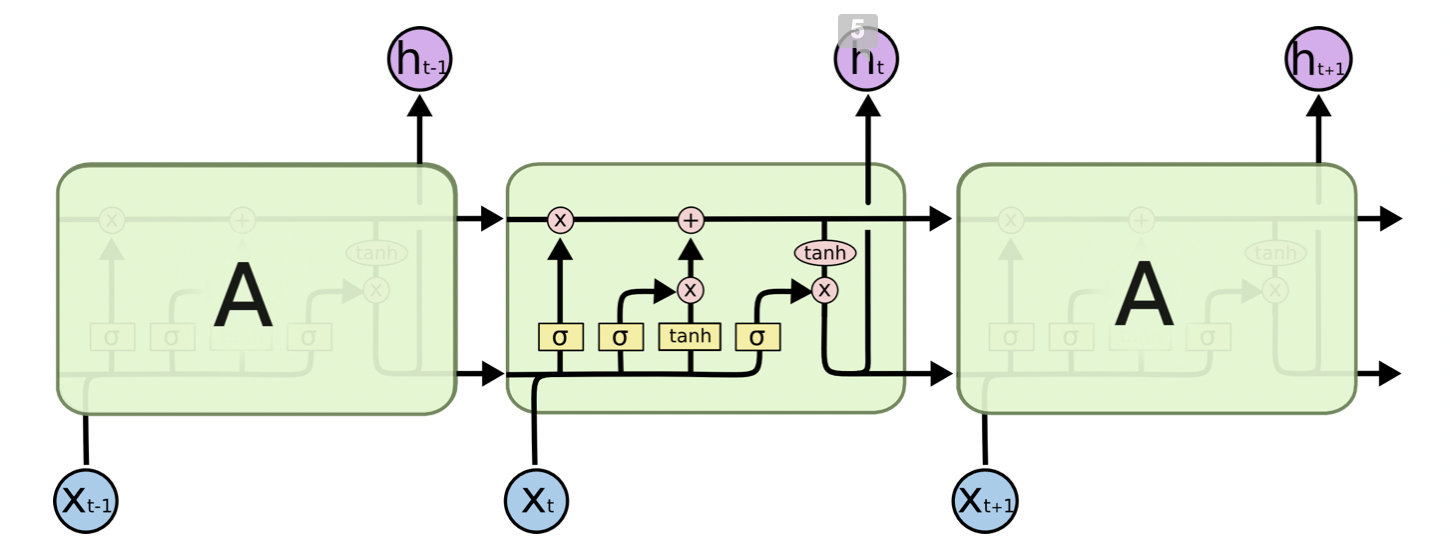

*Figure 6. General LSTM structure, taken from https://colah.github.io/posts/2015-08-Understanding-LSTMs/*

### Cell state

In RNNs, we transfer the information from the very beginning of the sequence to the very end via forward pass and then we backpropagate the error, that is we multiply the gradients pup until the very beginning of the sentence. However, what if we could simply "remember" the information for a long period of time. The cell state acts as the memory of the network in LST. The cell state acts as a "memory" of the LSTM, carrying information throughout the processing of the sequence. It can add or remove information to this memory via gates, allowing it to maintain information over long sequences:

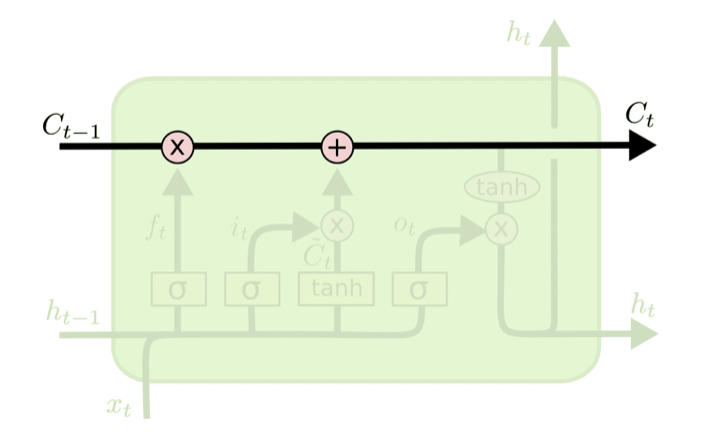

*Figure 7. The cell state of a unit in LSTM. The image taken from: https://colah.github.io/posts/2015-08-Understanding-LSTMs/*

The upper horizontal arrow running through all the cells is the "cell state", $C_t$. It is essentially meant to hold the long-term information that can flow through the network nearly unchanged. New information can be added or removed as regulated by cell gates.

Let's see how the input travels through the unit first.

### Forget Gate

First, the input, $x_t$, and the previous hidden state, $h_{t-1}$ goes through the forget gate. This gate determines how much of the cell state $C_{t-1}$ should be forgotten based on the previous hidden state and the current input.

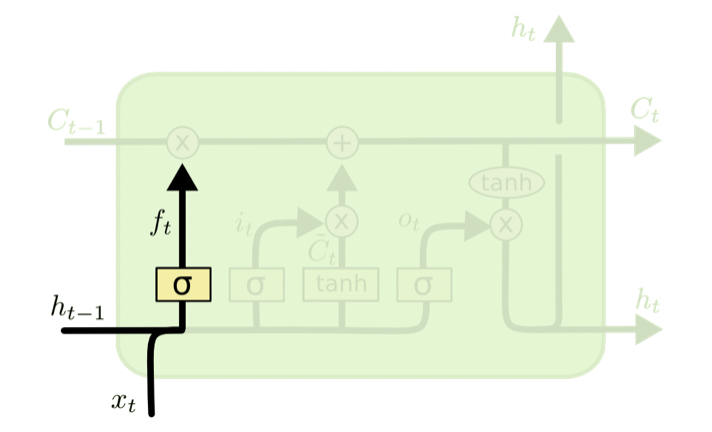

*Figure 8. The forget gate of LSTM, taken from https://colah.github.io/posts/2015-08-Understanding-LSTMs/.*

The output of the gate is calculated the following way:

$f_t = \sigma(W_f[h_{t-1}, x_t] + b_f)$

In this expression:<br>
$f_t$ - the output of the forget gate at time step t; <br>
$\sigma ()$ - the sigmoid activation function that converts the output to 0-1; <br>
$W_f$ - the forget gate weight matrix that is applied to the previous hidden state and current input concatenated vector;<br>
$[h_{t-1}, x_t]$ - concatenation of the previous hidden state and the current input. This essentially combines the current input with the past information that is held in the hidden state; <br>
$b_f$ - the bias term for the forget gate

Hence, in this function we combine the new input with previously held information, weight it, add the bias term to it and convert the output into values ranging from 0 to 1. This output then tells us the degree to which each component of the cell state $C_t-1$ should be retained or forgotten.

### Input Gate

This gate decides what new information the cell state is going to store. The sigmoid (“input gate layer”) decides which values from the cell state to update, and the tanh layer creates a vector of new candidate values, $C_t^{*}$.

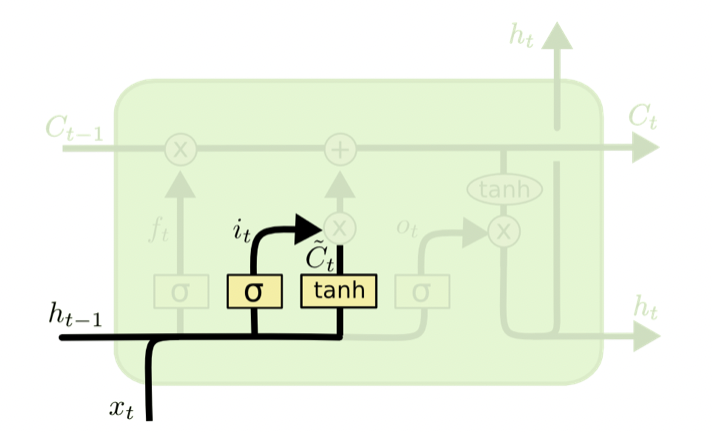

*Figure 9. The input gate of LSTM. This image is taken from: https://colah.github.io/posts/2015-08-Understanding-LSTMs/*

First, the model decides which values to update, using the following function:

$i_t = \sigma(W_i[h_{t-1}, x_t]+b_i)$

In the input gate activation function, $i_t$:<br>
$i_t$ - the output of the input gate at time t; <br>
$\sigma$ - the sigmoid activation function, converting the values to 0-1; <br>
$W_i$ - the input gate weight matrix that determines the values to be updated; <br>
$[h_{t-1}, x_t]$ - concatenation of the previous hidden state and the current input. This essentially combines the current input with the past information that is held in the hidden state; <br>
$b_i$ - the input gate bias term

Then, the model calculates the new candidate values for the cell state, using the following expression:

$C_t^* = tanh(W_C[h_{t-1}, x_t]+b_C)$

For the new candidate values, the unknown terms are: <br>
$C_t^*$ - the vector of the candidate values;<br>
$tanh$ - the activation function; <br>
$W_C$ - the weight matrix associated with the candidate values; <br>
$b_C$ - the bias term

Now that we have calculated what to forget and what values to update, we have to actually update the cell state:

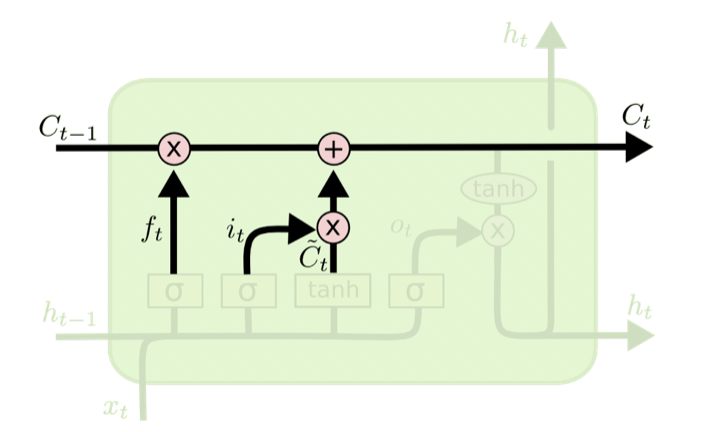

*Figure 10. The update process of the update gate in LSTM, the image taken from: https://colah.github.io/posts/2015-08-Understanding-LSTMs/*

$C_t = f_tC_{t-1} + i_tC_t^*$

Here, we multiply the old cell state by the forget gate output, effectively forgetting the values we decided to dismiss, and add the $i_tC_t^*$, the new cadidate values, which will update the cell state.

### Output Gate

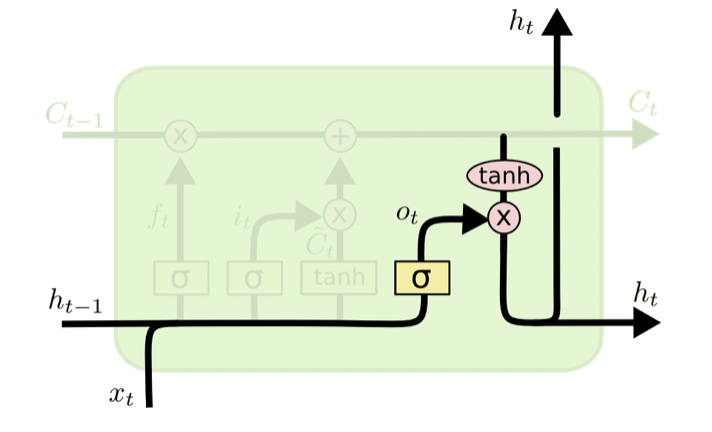

*Figure 11. The output gate of LSTM, which determines what to pass to the hidden state $h_t$. The image taken from: https://colah.github.io/posts/2015-08-Understanding-LSTMs/*

The output of the cell is the filtered version of the cell state. Unlike in RNNs, in LSTM we have to compute the output state for every time step because the output gate decides what should be passed to the hidden state $h_t$. First, we have a sigmoid layer that decides which parts of the cell state are relevant and should be outputted at the given time step. Values closer to 1 indicate that the corresponding component in the cell state is important and should be passed to the hidden state. The sigmoid layer output is calculated using the following formula:

$\sigma_t = \sigma(W_o[h_{t-1}, x_t]+b_o)$

The unknown terms in this calculation are: <br>
$W_o$ - the weight matrix associated with the output gate, determines what parts of the cell state to output; <br>
$b_o$ - the output gate bias term

After deciding which parts of the cell state to pass through, the entire cell state $C_t$ is processed through a tanh function to transform the values into -1 to 1 range. This helps to maintain the value range and avoid numbers getting too big or too small, and to maintain the scale consistency. Then, we multiply the tanh layer by the sigmoid layer so that the network only outputs the values it decided on:

$h_t = \sigma_ttanh(C_t)$

This way the new hidden state, $h_t$, contains only the components deemed important by the sigmoid layer and that these components are within a manageable range.

After the networks has worked through all the "sub-steps", it passes the updated cell state, $C_t$, and the hidden state, $h_t$, to the next cell to be used in the next time step calculation, along with the new inputs. This process of carrying the hidden and cell state to the next cell is similar to the normal feedforward propagation in the RNN networks. Ater the feedforward propagation, we then calculate the loss, and propagate it back via back propagation (described above in more detail). Then, we adjust the weights accordingly using gradient ddescent and cross-entropy as described above in the section on RNN, and continue to another feedforward interation until convergence.

### Transfer Learning

In transfer learning, we are essentially taking a pre-trained model (a model trained on a large dataset) and adapting it to a new, related task. This is particularly useful in deep learning, where training models from scratch requires a large amount of data and computational power. By using transfer learning, we can leverage the learned features and weights from the pre-trained model, making it easier to achieve good performance with less data on the new task. In this classification project I only have 200 songs from Burna Boy, Ariana Grande, Taylor Swift and 130 songs from Olivia Rodrigo, which might not be enough for the model to learn the data patterns in a meaningful way. This is because I had to use web scraping in order to obtain the data, which takes time. And, not to be caught, I had to use a ScrapeOps API which has a limit. Therefore, due to relatively small sample size, I believe it might be useful to implement transfer learning.

Transfer learning works by reusing the weights/learned features of a model pre-trained on a larger dataset. This is possible because in deep learning, the early layers of a neural network capture general features (like edges and textures in images), which are often transferable to new tasks. The model then can be fine-tuned on the new smaller dataset. One way to do so is by freezing the earlier layers and only training the last few layers of the model. This can be useful for the model to learn task-specific features learnt in the later layers.

## LDA: Latent Dirichlet Allocation

To further understand how similar the artists' lyrics are, or if they are singing about the same things, I am going to implement Latent Dirichlet Allocation model for topic modelling. Topic modelling allows one to deduce the topics that a given document discusses.

LDA in particular determines the distribution of words for each topic $K$, and the distribution of topics for every document $i$ given $M$ documents, $N$ words, and $K$ topics. The model has three key assumptions:



*   Every topic is made up of various words;
*   Every document consists of multiple topics;
*   Words appearing together are close semantically.



These assumptions make sense intuitively because we would expect to see certain words occuring in the "fashion" topic more often than in the "health" topic. Also, most documents touch upon multiple topics. However, these assumptions do simplify the problem. Specifically, not all words that are mentioned together are close semantically. Many words have multiple meanings and, thus, can play important roles in multiple topics.

### Bayesian Framework

An intuitive way to understand the math behind the model is to look at the Bayesian framework it is built upon. however, it is important to note that this framework is useful for conceotual understanding but the actual algorithm is described afterwards. I've discussed Bayesian inferrence in my first pipeline, where I introduced this formula:

$P(A|B) = \frac{P(A)P(B|A)}{P(B)}$

In the formula above, $P(A|B)$ is the posterior probability of teh event A occuring given that the event B has already happened. $P(A)$ is the prior probability of an event A, which denotes the probability that event A will happen. $P(B|A)$ is the likelihood, which is the probability that B happens given the evidence A. Lastly, $P(B)$ is the marginal probability, which is the probability of event B occurring.

**Posterior in LDA:** LDA's *goal* can then be framed as finding the posterior distributions ($P(A|B)$) of document-topic and topic-word distributions that most likely generated the observed documents.

**Prior in LDA:** The priors in LDA are the Dirichlet distributions for both the document-topic distributions and the topic-word distributions. These priors express our initial assumptions.

Dirichlet distribution is a continuous multivariate probability distribution, namely it is the multivariate generalization of the beta distribution. The document-topic and topic-word distributions are modelled using this distribution because: <br> <br> 1) it is a mathematical conjugate prior to a multinomial distribution (the likelihoods in LDA). This means that the posterior is the same as prior, which simplifies the computation of the posterior. <br> 2) It is very flexible due to its parameters that control how spread-out or concentrated the distribution is. The flexibility is especially important when modelling real world text data.

So, in LDA, both the document-topic and topic-word distributions are modelled using Dirichlet distributions with parameters $\alpha$ and $\beta$ accordingly. $\alpha$ influences the shape of the document-topic distribution. Specifically, it controls the density and concentration of topics within each document. A higher $\alpha$ leads to documents containing more uniform mix of topics, while a lower value would lead to documents dominated by fewer topics. $\beta$ determines the distribution of words within each topic. A higher $\beta$ value results in topics that are less concentrated around certain words (more words are likely to be relevant for a topic), whereas a lower value will lead the topics to be concentrated around fewer words.

Since $\alpha$ and $\beta$ represent out prior beliefs about the word-topic and document-topic distributions, they are not tuned during training. Rather, these are hyperparameters that we are able to set prior to the training that will influence the computation of the posterior since they determine the shapes of the distributions.

**Likelihood in LDA:** the likelihood of observing the words in the dicument given the distribution of topics and words. In other words, the likelihood quantifies how well the current model (with its topic assignments and distributions) explains the observed words in the documents.

*Calculating the likelihood* <br>
For every word, $N$, and every topic, $K$, we need to compute the following individual probabilities:

$P(N|K) = \frac{count(N, K)+\beta}{\sum_{N'}(count(N', k)+\beta)}$ <br><br>
In the equation above, $count(N, K)$ is the number of times the word $N$ is assigned to a topic $K$ acros all documents. $\beta$ is the Dirichlet prior for the topic-word distribution, as discussed above. The denominator is the sum over all words in the topic $K$, which normalizes the probability.

$P(K|D) = \frac{count(K, D)+\alpha}{\sum_{K'}(count(K', D)+\alpha)}$

In the equation above, $count(K, D)$ is the number of times the topic $K$ is assigned to words in a document $D$. $\alpha$ is the Dirichlet prior for the document-topic distribution. The denominator is the sum over all topics in the document $D$, which normalizes the probability.

The likelihood of a single word in the entire document is then a sum of the word probability over all the possible topics:

$P(N|D) = \sum_KP(N|K)xP(K|D)$

This calculation is then repeated for every word in the document. The overall likelihood of the entire dataset is the product of the individual word likelihoods, $P(K_i|D_j)$, where $K_i$ is the $i$th topic and $D_j$ is the $j$th document. However, in implementation, it is often more convenient to work with log likelihood due to its multiplicative nature.

*Note:* While understanding the likelihood is critical for theoretical and intuitive comprehension of the model, it is not calculated explicitly in LDA. During the iterative process of LDA (such as Gibbs sampling discussed below), what is actually calculated and updated are the topic assignments for each word and the distributions of topics in documents and words in topics. <br><br>
However, $P(N|D)$ underpins the calculation of perplexity, a metric used to evaluate the LDA performance. Perplexity measures how well a model predicts unseen data, and it is related to the average log likelihood of the words in a document, which is conceptually linked to $P(N|D)$.

**How do we calculate the posterior?**

In a purely Bayes' problem, we would multiply the likelihood by the priors and normalize it by the marginal probability to get the posterior. However, in LDA, the priors define how words and topics are distributed and impose certain contraints for how likelihood maximisation can operate. Thus, priors are always present in the likelihood calculation. In regards to normalization, the calculation is normalised during the Gibbs sampling and there is no need to calculate $P(B)$, marginal probability, which would be very computationally expensive.<br><br>
Thus, in LDA, we use an iterative algorithm like Gibbs sampling to adjust the topic and words assignments to maximise the overall word|document likelihood as can be estimated using perplexity.

### Step-by-Step Algorithm with Gibbs Sampling

Gibbs sampling is a Markov Chain Monte Carlo (MCMC) algorithm used for obtaining a sequence of samples from the joint probability distribution of multiple variables. To improve the topic distribution of each document and word distribution of each topic in LDA, we can use Gibbs sampling. Here is the LDA algorithm including teh interative process with Gibbs sampling:

**Step 1: Initialisation** <br>
Choosing the number of topics, $K$ for the LDA model to fit. In this step, we also randomly assign each word in each document to one of the K topics. We also choose the hyperparameters, $\alpha$ and $\beta$, for the document-topic and topic-word distributions.

**Step 2: Iteration using Gibbs sampling**<br>
For every document and every word in that document:
  1. Temporarily remove the current topic assignment;
  2. Calculate the conditional probabilities of assigning a word $N$ in a document $D$ to a topic $K$:

$P(K|N, D) \propto \frac{C_{TK}[K, N] + \beta}{\sum_{N'}(C_{TK}[K, N'] + \beta)} \times \frac{C_{DT}[D, K] + \alpha}{\sum_{K'}(C_{DT}[D, K'] + \alpha)}$


In the equation above:

$P(K|N, D)$ - the conditional probability of assigning topic K to word N in document D; <br>
$C_TK[K, N]$ - the count of word $N$ in a topic $K$ across all documents excluding the current topic assignment; <br>
$C_TK[D, K]$ - the count of topic $K$ in document $D$, excluding the current instance of the word; <br>
The sums are normalizing factors, summing over all words $N'$ in topic $K$ and all topics $K'$ in document $D$.

Word-Topic Compatibility: The first part of the formula assesses how well the word fits with the topic given the current assignments. <br>
Topic-Document Compatibility: The second part evaluates how prevalent the topic is in the document given its current composition.

  3. Sample new topic assignment
  In this step, we select a new topic assignment for the given word based on the computed probabilities. Once the new topic is assigned to the given word, we add one count to teh topic-document and topic-word matrices.

**Step 3: Repeating the process** <br>
  We then repeat the process described in step 2 for every word in every document until convergence.

**How should we define convergence?**

Since LDA is a generative model, it does not have a usual "loss function". So, in order to monitor the model's performance we can observe the stability of topic assignments. If the assignments change very little or not at all between successive iterations, it suggests that the model has reached a stable state. We can also use perplexity which measures how well the model predicts the sample.

**Perplexity** <br>
Perplexity is inversely related to the probability of the test data and can be thought of as a measure of how well the model predicts a sample. A lower perplexity score indicates a better generative model. The formula of perplexity is as follows:

$\text{Perplexity}(D_{\text{test}}) = \exp\left(-\frac{\sum_{d \in D_{\text{test}}} \log P(d)}{N_{\text{words in } D_{\text{test}}}}\right)
$

In the formula above, $D_{test}$ is a set of documents, $P(d)$ is the likelihood of each document given the model, $N_{words in D_{test}}$ is the total number of words in the document set.

This metric quantifies how probable the given document is under the created model. Specifically, this is achieved by $logP(d)$. These log likelihoods are then summed up and normalized by total word count. Then, we take the exponent of that to ensure an intepretable scale for the final value. As mentioned above, a smaller value of perplexity is better.

## Model Implementation

**Embedding:** For embedding in both Naive Bayes and logistic regression models, I am using tf-idf Vectorisation. TF-IDF vectorization is a numerical statistic that reflects the importance of a word to a document in a collection. Each word in the document represents a feature, and the value of that feature is determined by Td-Idf. There are two components to this vectorization. The first component is the term frequency, TF:

$\text{TF}(t, d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d}$


This component calculates the frequence of the word in the document.

The second component is the inverse document frequency, IDF:

$\text{IDF}(t, D) = \log\left(\frac{\text{Total number of documents in corpus } D}{\text{Number of documents with term } t \text{ in them}}\right)$

This term measures how much information the word provides across the document by decreasing the weight of terms that appear very frequently in the document and increasing the weight of terms that appear less frequently.

The TF-IDF value for a word in a document is the product of its TF and IDF scores:

$\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)$

### Naive Bayes'

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# Creating and Fitting Naive Bayes model
baseline_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
baseline_model.fit(train_data, train_labels)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Creating and fitting logistic regression model
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(multi_class = 'multinomial')),
               ])
logreg.fit(train_data, train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(multi_class='multinomial'))])

### LSTM

**Embedding:** In the following models, I am using TextVectoriser from tensorflow which converts words into integers. The number of words this layer can "learn" is limited to 500000 ("max_vocab"). The unknown words will be denoted as "UNK". This layer also standardises the input. Specifically,nit ensures that the soing lyrics are 190 words long ("max_len"). Then, I am passing the output of this layer into the "Embedding" layer which transforms every integer into a 128-dimensional vector ("output_dim"). These vectors capture semantic relationships of the words.

To implement the vectorization and embedding layers, I had to determine the "max_len" parameter, whcih would determine hat size every song lyrics would become eventually. That is why I decided to visualise the lengths distribution of the lyrics (below) and calculate the average length.

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
lengths = np.array([len(song.split()) for song in train_data])
average_length = np.mean(lengths)

print(f"The average length of a song is {average_length} words.")

The average length of a song is 179.1044520547945 words.


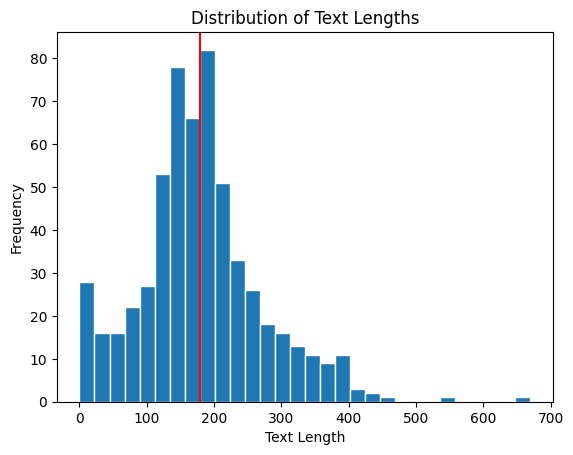

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'text_lengths' contains the length of each text in your dataset
plt.hist(lengths, bins=30, edgecolor = "white")
plt.axvline(np.mean(lengths), color = "r")
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

Looking at the distribution and the average lyrics length, I decided to set the maximum length to 190 so that there is a little room in between the average and maximum.

In [ ]:
max_vocab = 500000
max_length = 190

text_vectorizer = TextVectorization(max_tokens = max_vocab,
                                    output_mode = 'int',
                                    output_sequence_length = max_length)
text_vectorizer.adapt(train_data)

In [ ]:
learned_words = text_vectorizer.get_vocabulary()
print(f'Top 10 most common words: {learned_words[:10]}')
print(f'Least common 10: {learned_words[-10:]}')

Top 10 most common words: ['', '[UNK]', 'know', 'oh', 'dont', 'love', 'up', 'go', 'say', 'yeah']
Least common 10: ['abodi', 'aboard', 'abnormal', 'abloh', 'abegi', 'abbot', 'abandoned', 'aahs', 'aaay', 'aaah']


In [ ]:
embedding = layers.Embedding(input_dim = max_vocab, # max lyrics langth
                             output_dim = 128, # each int is transformed into a 180-simensional vector
                             input_length = max_length, # max input length
                             name = "embedding_layer")

In [ ]:
inputs = layers.Input(shape = (1,), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, return_sequences = True)(x)
x = layers.LSTM(32, return_sequences = True)(x)
x = layers.Dropout(0.6)(x)
x = layers.LSTM(16, return_sequences = True)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation = "relu")(x)
x = layers.Dropout(0.6)(x)
outputs = layers.Dense(4, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name = "Model_1_LSTM")

The model has a vectorzation layer, embedding layer, two LSTM layers. I added a DropOut layer to reduce overfitting.  The Dropout layer randomly sets a proportion of the output units of the previous layer to zero. Specifically, the layers. Dropout(0.6) means that 60% of the units in the output of the previous layer are randomly turned off during training, forcing the network to learn more robust features. Then, I added one more LSTM layer and a global average pooling layer which computes the average of each feature across the time dimension, effectively simplifying the model. This also helps reduce overfitting. Then, the model has dense layers and a dropout layer. The architecture is displayed below.

In [ ]:
# model architecture
model_1.summary()

Model: "Model_1_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 190)               0         
 ctorization)                                                    
                                                                 
 embedding_layer (Embedding  (None, 190, 128)          64000000  
 )                                                               
                                                                 
 lstm_3 (LSTM)               (None, 190, 64)           49408     
                                                                 
 lstm_4 (LSTM)               (None, 190, 32)           12416     
                                                                 
 dropout_3 (Dropout)         (None, 190, 32)          

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Early Stopping to prevent overfitting and stop training when the model is not improving
es = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                      patience = 5,
                                      verbose = 1)
# Reducing the learning rate when there is no improvement
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

In [ ]:
# Compiling and training the model
model_1.compile(loss = "sparse_categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
# Recording the training process
model_1_history = model_1.fit(x = train_data,
                              y = train_labels,
                              epochs = 20,
                              validation_data = (val_data, val_labels),
                              callbacks = [es, reduce_lr])

Epoch 1/20
19/19 [==============================] - 11s 289ms/step - loss: 1.3450 - accuracy: 0.4555 - val_loss: 1.2665 - val_accuracy: 0.4247 - lr: 0.0010
Epoch 2/20
19/19 [==============================] - 3s 157ms/step - loss: 1.0950 - accuracy: 0.5908 - val_loss: 1.0690 - val_accuracy: 0.5205 - lr: 0.0010
Epoch 3/20
19/19 [==============================] - 3s 139ms/step - loss: 0.8077 - accuracy: 0.7038 - val_loss: 1.1290 - val_accuracy: 0.5068 - lr: 0.0010
Epoch 4/20
19/19 [==============================] - 3s 147ms/step - loss: 0.7087 - accuracy: 0.7055 - val_loss: 1.2539 - val_accuracy: 0.4384 - lr: 0.0010
Epoch 5/20
19/19 [==============================] - 4s 218ms/step - loss: 0.5748 - accuracy: 0.7534 - val_loss: 0.8748 - val_accuracy: 0.6575 - lr: 0.0010
Epoch 6/20
19/19 [==============================] - 3s 142ms/step - loss: 0.4624 - accuracy: 0.8870 - val_loss: 0.7702 - val_accuracy: 0.7397 - lr: 0.0010
Epoch 7/20
19/19 [==============================] - 3s 134ms/step - l

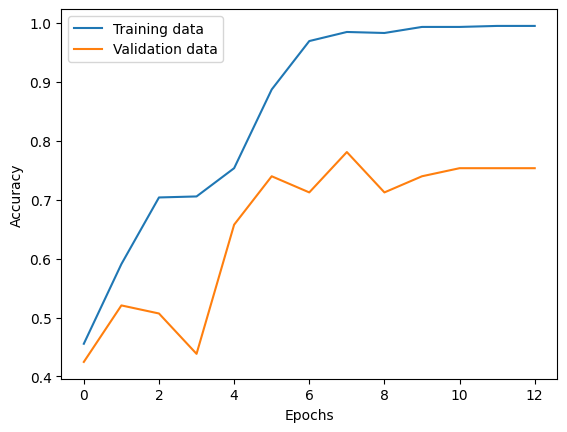

In [ ]:
# Plotting the training process
plt.plot(model_1_history.history['accuracy'], label = "Training data")
plt.plot(model_1_history.history['val_accuracy'], label = "Validation data")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

We see that despite the DropOut and pooling layers, the model still overfits. Specifically, the difference between the training and validation accuracy is 20%. This means that the model learns training-specific features and has trouble generalizing them to unseen data. However, this is the best performance I've achieved (I've reduced the number of neurons in LSTM, added more DropOut and the callbacks to the original model) so far.

### Transfer Learning

For transfer learning, I am using universal sentence encoder model. USE is a pre-trained model developed by Google that encodes text into high-dimensional vectors. This model provides meaningful numerical word representations that capture semantic meanings of words. I am adding two Dense layers on top of the USE layer.

In [ ]:
import tensorflow_hub as hub

encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                               input_shape = [], # bc it takes in "variable length"
                               dtype = tf.string,
                               trainable = False,
                               name = "USE")

In [ ]:
tl_model = tf.keras.Sequential([
    encoder_layer,
    layers.Dense(128, activation = "relu"),
    layers.Dense(64, activation = "relu"),
    layers.Dense(4, activation = "softmax")
], name = "tl_model")


In [ ]:
tl_model.summary()

Model: "tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_15 (Dense)            (None, 128)               65664     
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 4)                 260       
                                                                 
Total params: 256872004 (979.89 MB)
Trainable params: 74180 (289.77 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
tl_model.compile(loss = "sparse_categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

tl_model_history = tl_model.fit(x = train_data,
                              y = train_labels,
                              validation_data = (val_data, val_labels),
                              epochs = 20,
                              callbacks = [es, reduce_lr])

Epoch 1/20
19/19 [==============================] - 5s 56ms/step - loss: 1.3355 - accuracy: 0.3938 - val_loss: 1.2235 - val_accuracy: 0.5342 - lr: 0.0010
Epoch 2/20
19/19 [==============================] - 1s 28ms/step - loss: 1.1611 - accuracy: 0.6284 - val_loss: 1.0147 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 3/20
19/19 [==============================] - 1s 29ms/step - loss: 0.9165 - accuracy: 0.7055 - val_loss: 0.8380 - val_accuracy: 0.6575 - lr: 0.0010
Epoch 4/20
19/19 [==============================] - 1s 28ms/step - loss: 0.7235 - accuracy: 0.7825 - val_loss: 0.7233 - val_accuracy: 0.7260 - lr: 0.0010
Epoch 5/20
19/19 [==============================] - 1s 29ms/step - loss: 0.5865 - accuracy: 0.8151 - val_loss: 0.6356 - val_accuracy: 0.7397 - lr: 0.0010
Epoch 6/20
19/19 [==============================] - 1s 29ms/step - loss: 0.4892 - accuracy: 0.8596 - val_loss: 0.5734 - val_accuracy: 0.7945 - lr: 0.0010
Epoch 7/20
19/19 [==============================] - 1s 30ms/step - loss: 0.4

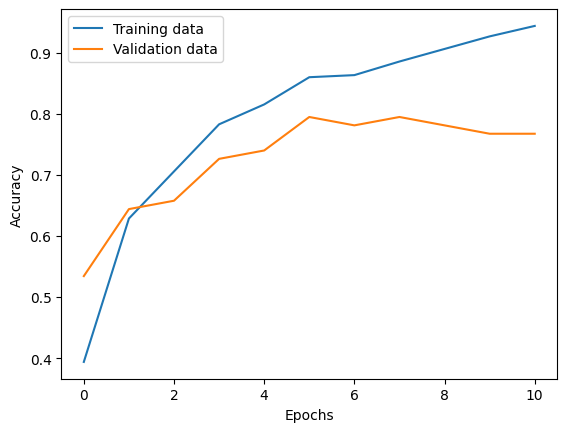

In [ ]:
# Visualizing the training process
plt.plot(tl_model_history.history['accuracy'], label = "Training data")
plt.plot(tl_model_history.history['val_accuracy'], label = "Validation data")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

We see that the validation accuracy starts to fall around epoch 8, while the training accuracy continues to rise. The model also overfits. The difference between the training and validation accuracy is similar to the previous model, namely it is around 20%.

### Newly added: LDA

In this section, I am implementing LDA topic modelling for each artist. For this, I am analysing all the lyrics I webscraped for every artist separately.

In [ ]:
ariana_grande_lda = ariana_grande_cleaned.drop("Link", axis = 1)
burna_boy_lda = burna_boy_cleaned.drop("Link", axis = 1)
olivia_rodrigo_lda = olivia_rodrigo_cleaned.drop("Link", axis =1)
taylor_swift_lda = taylor_swift_cleaned.drop("Link", axis =1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

artists_dfs = [ariana_grande_cleaned, burna_boy_cleaned, olivia_rodrigo_cleaned, taylor_swift_cleaned]
artist_topics = {}

for artist_df in artists_dfs:
    artist_name = artist_df['Artist'].iloc[0]
    lyrics = artist_df['Lyrics']

    vectorizer = CountVectorizer()
    song_term_matrix = vectorizer.fit_transform(lyrics)
    lda = LatentDirichletAllocation(n_components=3, random_state=42)
    lda.fit(song_term_matrix)

    # Store the LDA model, vectorizer, and term matrix
    artist_topics[artist_name] = (lda, vectorizer, song_term_matrix)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def display_top_words(model, feature_names, no_top_words):
  """
  Displays the top words for each topic from an LDA model.

  Parameters:
  model (LatentDirichletAllocation): The trained LDA model.
  feature_names (List[str]): A list of feature names (words) as extracted by the vectorizer.
  no_top_words (int): The number of top words to display for each topic.
  """
  for topic_idx, topic in enumerate(model.components_):
      print("Topic %d:" % (topic_idx))
      print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

for artist_name, (lda_model, vectorizer) in artist_topics.items():
    print(f"Top 10 words for each topic for {artist_name}:")
    feature_names = vectorizer.get_feature_names_out()
    display_top_words(lda_model, feature_names, 10)
    print("\n")

Top 10 words for each topic for Ariana Grande:
Topic 0:
know la back one got oh ayy less baby let
Topic 1:
love up know got baby way want with make wanna
Topic 2:
baby know love oh rain let got heart up with


Top 10 words for each topic for Burna Boy:
Topic 0:
go dey say know make baby up time want tell
Topic 1:
dey go oh make mi see pa ma won mo
Topic 2:
dey say oh know dem ah na mi go bad


Top 10 words for each topic for Olivia Rodrigo:
Topic 0:
th usa know with never think good love one strange
Topic 1:
know cant think love with go way now oh ive
Topic 2:
wanna oh back want know with got up love now


Top 10 words for each topic for Taylor Swift:
Topic 0:
never love up want oh wish time back one look
Topic 1:
know now never oh back with love time see got
Topic 2:
know with one time go up wanna say love now




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Upon visual inspection, we see that the identified topics are not very different from one another. We can generally notice words like "baby" and "love" in most of the topics. This might be because the identified topics are very close to one another or the topics might simply be more artificial, meaning that N_topics of 3 might be too much for the artists because they sing about one topic mostly. We will have a clearer understanding of the topics when visualising the LDA in the next section.

## Performance metrics & Visualisations

### Naive Bayes

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
# Naive Bayes predictions
y_pred_nb = baseline_model.predict(test_data)
accuracy_nb = accuracy_score(y_pred_nb, test_labels)
f1_nb = f1_score(y_pred_nb, test_labels, average = "weighted")

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

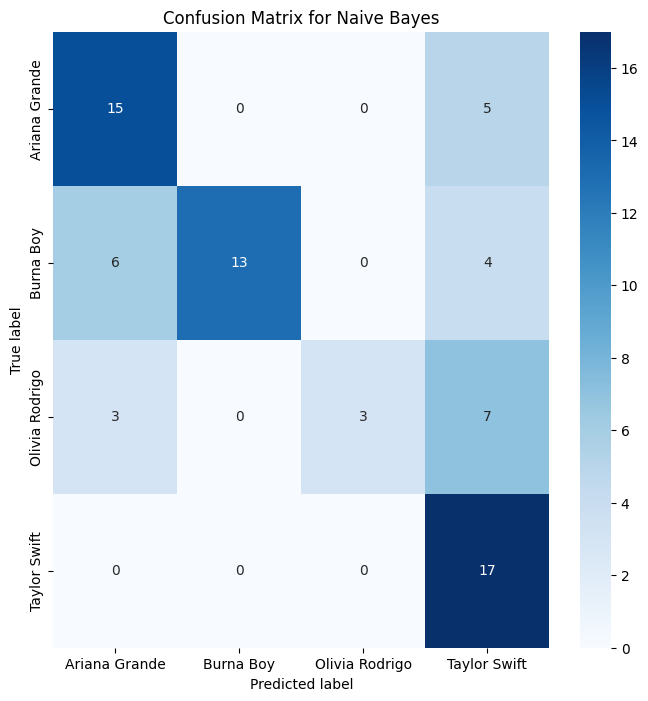

In [ ]:
cm_nb = confusion_matrix(test_labels, y_pred_nb)
classes = artist_mapping.keys()
# Plotting confusion matrix
plot_confusion_matrix(cm_nb, classes, title= "Confusion Matrix for Naive Bayes")

In [ ]:
print(f"The Naive Bayes' accuracy score: {accuracy_nb}")
print(f"The Naive Bayes' f1-score: {f1_nb}")

The Naive Bayes' accuracy score: 0.6575342465753424
The Naive Bayes' f1-score: 0.6755825377058253


We see that Naive Bayes is not performing very well. Specifically, its accuracy score on the test data is 65%, and the f1-score is 67%. These scores are definitely better than guessing, which means that the model does learn something about the data. Looking at the confusion matrix, we see that we have much less data from Olivia Rodrigo, which is expected given our dataset (there are only 130 Olivia Rodrigo songs). We can also see that Olivia Rodrigo's songs are confused with Ariana Grande's songs 50% of the time. Some of Taylor Swift's songs are mistaken for Ariana Grande's songs as well. Surprisingly, Burna Boy's songs are also mistaken for Ariana Grande's songs.

### Logistic Regression

In [ ]:
# Logistic Regression predictions
y_pred_lr = logreg.predict(test_data)
# Metrics calculation
accuracy_lr = accuracy_score(y_pred_lr, test_labels)
f1_lr = f1_score(y_pred_lr, test_labels, average = "weighted")

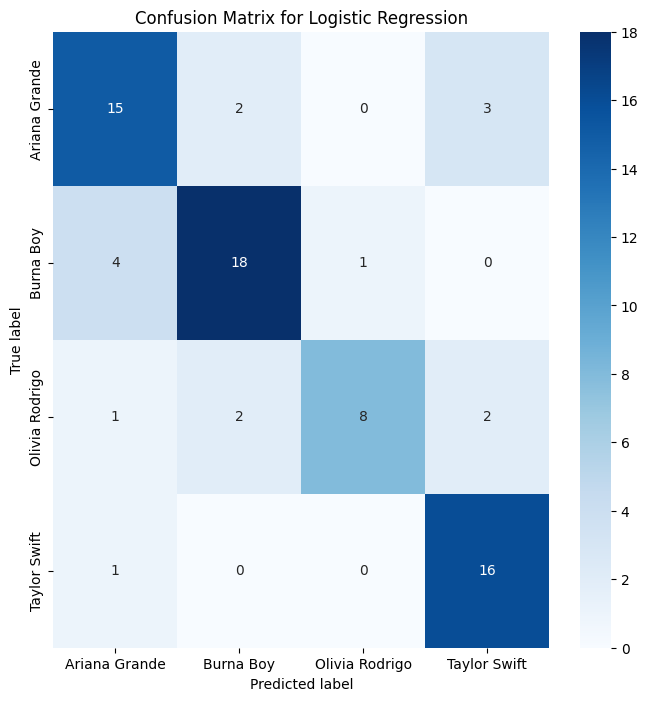

In [ ]:
cm_lr = confusion_matrix(test_labels, y_pred_lr)
classes = artist_mapping.keys()

# For each model
plot_confusion_matrix(cm_lr, classes, title= "Confusion Matrix for Logistic Regression")

In [ ]:
print(f"The Logistic Regression accuracy score: {accuracy_lr}")
print(f"The Logistic regression f1-score: {f1_lr}")

The Logistic Regression accuracy score: 0.7808219178082192
The Logistic regression f1-score: 0.7835002565795469


We see that Logistic Regression Model is doing much better than Naive Bayes' model with accuracy and f1-score of ~78%. Looking at the logistic regression confusion matrix, we see that logistic regression does much better differentiating Olivia Rodrigo's songs than Naive Bayes' did. Moreover, overall, logistic regression model does not confuse the artists as much.

### Deep Learning: LSTM

In [ ]:
# LSTM model predictions
model_1_pred_probs = model_1.predict(test_data)
lstm_pred = tf.squeeze(model_1_pred_probs.argmax(axis = 1))
# Metrics
accuracy_lstm = accuracy_score(lstm_pred, test_labels)
f1_lstm = f1_score(lstm_pred, test_labels, average = "weighted")

3/3 [==============================] - 1s 18ms/step


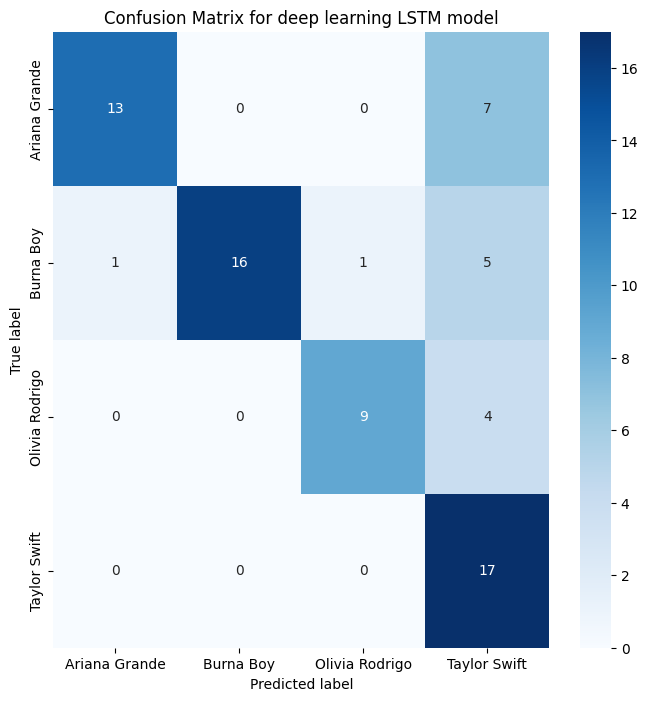

In [ ]:
cm_lstm = confusion_matrix(test_labels, lstm_pred)
classes = artist_mapping.keys()
# Confusion Matrix plot
plot_confusion_matrix(cm_lstm, classes, title= "Confusion Matrix for deep learning LSTM model")

In [ ]:
print(f"The LSTM accuracy score: {accuracy_lstm}")
print(f"The LSTM f1-score: {f1_lstm}")

The LSTM accuracy score: 0.7534246575342466
The LSTM f1-score: 0.7410982799680554


Surprisingly, LSTM model does worse than logistic regression model above. Specifically, its accuracy and f1-score are ~3% worse than those of the logistic regression model. Comparing the confusion matrices, we see that this model confuses artists more frequently, namely, it confused Taylor Swift lyrics with those of Ariana Grande 7 times, while the previous model confused lyrics of the same two artists maximum 4 times.

### Transfer Learning: USE

In [ ]:
# Transfer Learning predictions
model_tl_pred_probs = tl_model.predict(test_data)
tl_pred = tf.squeeze(model_tl_pred_probs.argmax(axis = 1))
# Metrics
accuracy_tl = accuracy_score(tl_pred, test_labels)
f1_tl = f1_score(tl_pred, test_labels, average = "weighted")

3/3 [==============================] - 1s 38ms/step


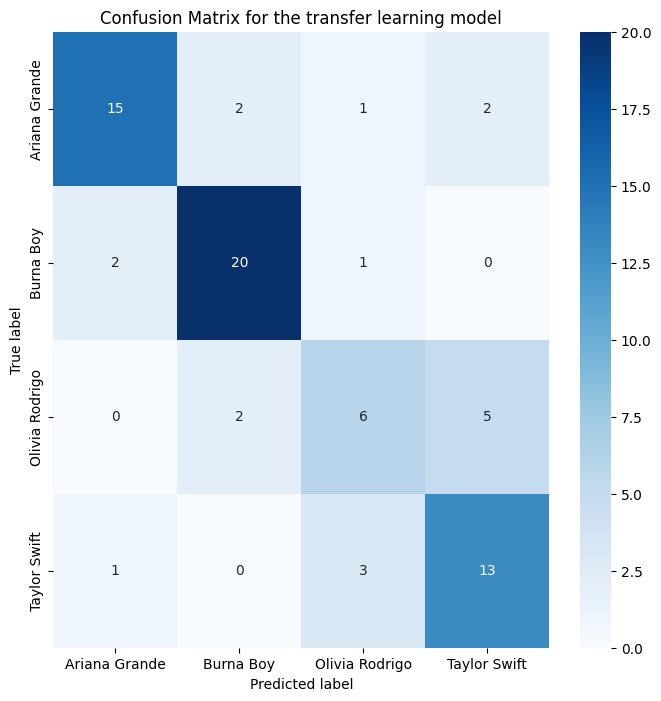

In [ ]:
cm_tl = confusion_matrix(test_labels, tl_pred)
classes = artist_mapping.keys()
# Confusion Matrix plot
plot_confusion_matrix(cm_tl, classes, title= "Confusion Matrix for the transfer learning model")

In [ ]:
print(f"The transfer learning model accuracy score: {accuracy_tl}")
print(f"The transfer learning model f1-score: {f1_tl}")

The transfer learning model accuracy score: 0.7397260273972602
The transfer learning model f1-score: 0.7423303052703719


While the model does pretty well overall, it does worse than the previous LSTM model and logistic regression. Looking at the confusion matrix, we see it has the most trouble classifying Olivia Rodrigo. However, this model does the best classifying Burna Boy lyrics, which is quite interesting. Perhaps, because the model is pre-trained on a larger dataset, it distinguishes non-English words better than the previous models.

### All models comparison

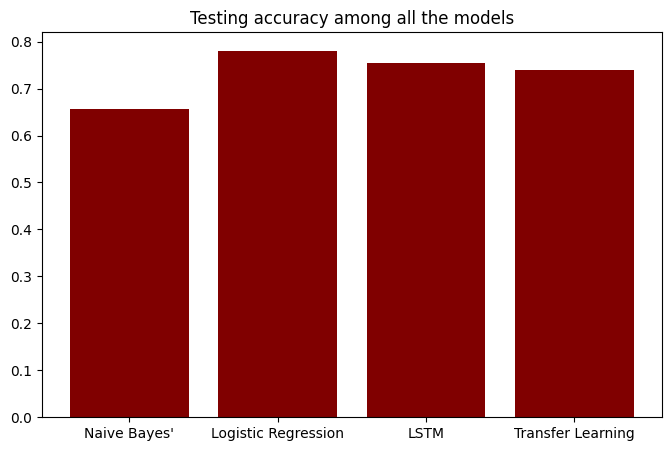

In [ ]:
labels = ["Naive Bayes'","Logistic Regression", "LSTM", "Transfer Learning"]
vals = [accuracy_nb, accuracy_lr, accuracy_lstm, accuracy_tl]
plt.figure(figsize = (8, 5))
plt.bar(labels, vals, color = 'maroon')
plt.title("Testing accuracy among all the models")
plt.show()

We see that the logistic regression model has the highest accuracy followed by LSTM. This is an interesting result that I did not expect. This might be due the tendency of more complex models like LSTM to overfit, undermining its performance on unseen data, while logistic regression is able to capture the main patterns (unline Naive Bayes') yet not to overfit.

### Newly added: LDA Visualisations

In this section, I am visualising the LDA modelling results. The visualisations shows a graphic representation of topics extracted from the documents, and shows how the topics are positioned in relation to one another.

**Taylor Swift**

In [ ]:
import pyLDAvis
# Extracting the model, vectoriser and term matrix
taylor_swift_lda_model, taylor_swift_vectorizer, taylor_swift_term_matrix = artist_topics["Taylor Swift"]

# Preparing data for pyLDAvis
topic_term_dists = taylor_swift_lda_model.components_
doc_topic_dists = taylor_swift_lda_model.transform(taylor_swift_term_matrix)
doc_lengths = taylor_swift_term_matrix.sum(axis=1).getA1()
term_freqs = taylor_swift_term_matrix.sum(axis=0).getA1()
vocab = taylor_swift_vectorizer.get_feature_names_out()

# Displaying the data with pyLDAvis
prepared_data = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_freqs,
    mds='tsne'
)
pyLDAvis.display(prepared_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking at topic 1, we see that the most frequent words are "know", "never", "now", "back", "time", etc. These words imply that the first topic might be about reminiscence and personal reflections. <br><br>
Topic 2's most frequent words are "know", "one", "time", "go", "wanna", "say", "love", etc. While topic 2 appears quite similar to topic 1, I believe there is more emphasis on the present moment (now) and action than in the first topic. <br><br>
Topic 3 is similar to topic 1 in its most frequent words. Specifically, the most frequent words are: "never", "love", "up", "wish", "time", etc. These words signal that the topic can be about regret, past and ersonal reflections like the first topic.

**Ariana Grande**

In [ ]:
# Extracting the model, vectoriser and term matrix
ariana_grande_lda_model, ariana_grande_vectorizer, ariana_grande_term_matrix = artist_topics["Ariana Grande"]

# Preparing data for pyLDAvis
topic_term_dists = ariana_grande_lda_model.components_
doc_topic_dists = ariana_grande_lda_model.transform(ariana_grande_term_matrix)
doc_lengths = ariana_grande_term_matrix.sum(axis=1).getA1()
term_freqs = ariana_grande_term_matrix.sum(axis=0).getA1()
vocab = ariana_grande_vectorizer.get_feature_names_out()

# Displaying the data with pyLDAvis
prepared_data = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_freqs,
    mds='tsne'
)
pyLDAvis.display(prepared_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Analysing the visualisation above, one can see that topic 1 and 2 are quite alike. Specifically, topic 1 includes words like "love", "baby", "know", which are also ones of the most frequently occuring words in topic 2. However, topic 2 has less focus on words connceted to desire such as "wanna", "want". This implies that while both topics are about emotions and relationships, topic 1 has a stronger emphasis on desire. Topic 3 has words like "know", "back", "one", "got". This means that this topic is less about personal relationships and more about reflections and past.

**Olivia Rodrigo**

In [ ]:
# Extracting the model, vectoriser and term matrix
olivia_rodrigo_lda_model, olivia_rodrigo_vectorizer, olivia_rodrigo_term_matrix = artist_topics["Olivia Rodrigo"]

# Preparing data for pyLDAvis
topic_term_dists = olivia_rodrigo_lda_model.components_
doc_topic_dists = olivia_rodrigo_lda_model.transform(olivia_rodrigo_term_matrix)
doc_lengths = olivia_rodrigo_term_matrix.sum(axis=1).getA1()
term_freqs = olivia_rodrigo_term_matrix.sum(axis=0).getA1()
vocab =olivia_rodrigo_vectorizer.get_feature_names_out()

# Displaying the data with pyLDAvis
prepared_data = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_freqs,
    mds='tsne'
)
pyLDAvis.display(prepared_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 1's most common words here are "know," "cant," "think", and "love". these words indicate that the topic can be about emotional expression and the presence of words like "now" convey a sense of emergency. <br><br>
Topic 2 includes words like "usa", "know", "strange","think", which implies that the topic can be about more abstract ideas and introspection.<br><br> Similarly to one of the topics identified in Taylor Swift work, topic 3 here is about personal relationships and love with a focus on desire due to the presence of such words as "wanna" and "want".

**Burna Boy**

In [ ]:
burna_boy_lda_model, burna_boy_vectorizer, burna_boy_term_matrix = artist_topics["Burna Boy"]

# Extracting the model, vectoriser and term matrix
topic_term_dists = burna_boy_lda_model.components_
doc_topic_dists = burna_boy_lda_model.transform(burna_boy_term_matrix)
doc_lengths = burna_boy_term_matrix.sum(axis=1).getA1()
term_freqs = burna_boy_term_matrix.sum(axis=0).getA1()
vocab =burna_boy_vectorizer.get_feature_names_out()

# Displaying the data with pyLDAvis
prepared_data = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_freqs,
    mds='tsne'
)
pyLDAvis.display(prepared_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Burna Boy's topics are a little more difficult to identify because I think I did not realise that he uses a lot of foreign words. <br><br> Topic 1 includes words like "say", "know", "go", "dey", "come", and "make". This suggests that this topic might have more of a focus on storytelling, personal relationships, and action. The words the meaning of which I can understand from topic 2 appear to be very similar to topic 1. Both topic 1 and 2 have a liguistic and cultural focus, and use a lot of non-English words. <br><br>
However, topic 3 appears to have more english words like "say", "know", "baby", "make", etc. While the words are the same as in the previous two topics, this topic includes significantly fewer foreign words and, thus, might be more focused on personal relationships without a cultural aspect integartion.

#### Artist topics comparison

Ariana Grande's topics suggest a focus on personal and intimate aspects of relationships, with emotional depth and direct communication being central themes. <br><br>
Burna Boy shows a strong cultural element in his lyrics, with topics related to personal relationships and communication.<br><br>
Olivia Rodrigo's topics seem to center around introspection, immediate emotional experiences, and personal thoughts.<br><br>
Taylor Swift's topics indicate a strong narrative element, focusing on personal stories, reflections, and contemplation of the past. <br><br>
Overall, we can see that the artists mostly sing about personal relationships and their introspective thoughts with different degrees of focus on action, emotional depth, or desire. Burna Boy mostly uses non-English words, which distinguishes him from the rest of the artists in this project. This means that it should be relatively easy for the models to distunguish the artist from the rest.

## Discussion & Summary

The overview of this project is the following:
1. Webscraping the data;
2. Converting the data into pandas;
3. Data cleaning & pre-processing;
  a. Explaratory Data Analysis (Wordclouds);
4. Task Discussion (splitting the data into training, validation, and test sets);
5. Model Selection; <br>
  a. Feedforward networks discussion;<br>
  b. Backpropagation & gradient descent;<br>
  c. RNNs;<br>
  d. LSTMs;<br>
  e. Transfer Learning;<br>
6. Implementing the models;
7. Performance metrics, predictions & visualisations;

Looking at the previous section, we can conclude that the logistic regression model had the highest scores and outperformed other models. While I had expected deep neural networks and transfer learning to perform the best, it makes sense that the model performs a little bit better than the more complex models. This is likely due to the tendency to overfit the training data that the more complex models have. Looking at the logistic regression model's confusion matrix, one can see that the model does not confuse the lyrics often. Specifically, the maximum number of times it confused the same two artists is 4. This means that there are no two artists that have such similar lyrics.

We can attempt to answer the question that motivated this project now. In particular, we can attempt to answer the question of whether pop artists write the same lyrics and sing about the same things. Analyzing the performance of the logistic regression model, we can infer that the model does differentiate all pop artists (Olivia Rodrigo, Ariana Grande, Taylor Swift) well. This suggests that their writing is different and they do not write about the same things. Thus, pop music is different. However, the model is more confident about classifying Burna Boy, which can mean that while the pop songs are not the same they might differ from the songs of the same genre less than from songs of another genre.

The addition of LDA topic modelling helped answer the broader question I posed at the beginning of the project. In particular, "Do all artists sing about the same things?". Analysing the LDA visualisations, we saw that all artists included in the assignment sing about similar topics such as personal relationships and emotions. However, there is a distinct difference between the three pop artists and Burna Boy. More specifically, Burna Boy's lyrics include more cultural aspects. The other three artists do sing about similar topics with little distinctions in what they put more focus on, - action or desire, etc. Generally, after analysing the LDA visualisations, I would conclude that the topics all three pop artists raise are quite similar. However, as we have seen in the prior analyses, machine learning could differentiate between the songs quite well, which means that even though the topics the artists sing about are similar, they are not identical. The machine learning's ability to differentiate between the artists can be pointing at that the artists can be using different grammatical structure or use words/topics in a unique pattern that machine learning can infer.

It should be noted that the data was randomly shuffled before the random training-validation-test split, however, Burna Boy's songs were represented more than Olivia Rodrigo's songs in the test set. This is also because I only web-scraped 130 Olivia Rodrigo songs and 200 songs from all other artists. The combination of random chance and the web scraping process might have contributed to the model being more confident about classifying Burna Boy's songs. However, Olivia Rodrigo's songs are classified the most poorly across all the models, which can be attributed to their underrepresentation in the data, which is one of the shortcomings of this project.

Another shortcoming of the project is the lack of data. While I web-scraped more data than I had in my first assignment, I think the models might have performed better if they had larger quantities and more diverse data (for example from more artists). This would have allowed models to learn more general patterns in the data, leading to better performance on unseen data because of the models' increased ability to generalize.

In addition to obtaining more data, another extension of this work would be trying out more model architectures, as well as other models such as SVMs.

## AI Statement

I used ChatGPT to clarify my understanding of the logic behind feedforward networks, backpropagation, gradient descent, RNNs, LSTMs, and Transfer Learning. It was incredibly helpful to chat with it to ensure that I understood the mechanisms behind these models correctly from my independent research. I also used ChatGPT to write doc strings.

## References

Li, S. (2018, September 25). Multi-Class Text Classification Model Comparison and Selection. Towards Data Science; Towards Data Science. https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568Nabi, J. (2019, July 21). <br><br>Recurrent Neural Networks (RNNs). Medium. https://towardsdatascience.com/recurrent-neural-networks-rnns-3f06d7653a85Olah, C. (2015, August 27). <br><br>Understanding LSTM Networks. Github.io. https://colah.github.io/posts/2015-08-Understanding-LSTMs/Singh, S. (n.d.). <br><br>How to Use Naive Bayes for Text Classification in Python? Www.turing.com. Retrieved November 27, 2023, from https://www.turing.com/kb/document-classification-using-naive-bayes#how-to-execute-naive-bayes-in-pythontf.keras.layers.Embedding <br><br>TensorFlow Core v2.9.1. (n.d.). TensorFlow. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding